In [2]:
import requests
from os import listdir
import urllib.request
import json
import glob
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import pylab as pl
import numpy as np
import pandas as pd
from ast import literal_eval
from interruptingcow import timeout
from collections import Counter


# import cv2
import skimage
from PIL import Image
from skimage.io import imread
from scipy.misc import imresize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import *
from keras.utils import np_utils, to_categorical, Sequence
from keras import backend as K,objectives
from keras.losses import mse, binary_crossentropy
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop, SGD
from keras.initializers import RandomNormal
from keras import applications
import random

import tensorflow as tf

from pandas import DataFrame
from collections import OrderedDict
import seaborn as sns
%matplotlib inline


# check the status of GPU
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:1']

In this notebook, we provide more implementation details of our project. To benefit your reading, we summarize our topics in the notebook below:
# Outline
- 1. Data Preprocessing
    - 1.1 DataSet Chosen and Augmentation
    - 1.2 Exploratory Data Analysis
    - 1.3 Data Balancing
- 2. Model Preparation
    - 2.1 Processing features and response
    - 2.2 Train, Test, Validation Split
- 3. Modeling
    - 3.1 Baseline CNN
    - 3.2 GoogleNet (Inception V3)
    - 3.3 VGG-19
    - 3.4 ResNet
    - 3.5 Model Comparison
- 4. Attack Methods
    - 4.1 Saliency Maps and Fast Gradient Methods(FGM)
    - 4.2 Fast Gradient Sign Methods(FGSM)
    - 4.3 Iterative Fast Gradient Sign Methods(I-FGSM)
    - 4.4 Iterative Fast Gradient Sign Methods(I-FGSM) with target
    - 4.5 Optimization based method
    - 4.6 LBFGS
- 5. Results
    - 5.1 Evaluation of Attack Successful Rate
    - 5.2 Evaluation of Transferability
        - 5.2.1 Non-targeted Attack
        - 5.2.2 Targeted Attack


In [11]:
def get_session():
    """Create a session that dynamically allocates memory."""
    # See: https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

tf.reset_default_graph()
sess = get_session()

K.set_session(sess)

## 1.Data Preprocessing

### 1.1 DataSet Chosen and Augmentation

The original PubFig data (http://www.cs.columbia.edu/CAVE/databases/pubfig/) contains 58,797 images for 200 people. For downloading, PubFig provides a $.txt$ file both for training (60 Fig) and evaluation, each contains:
- the person name,
- the image number for that person,
- the original image URL,

However, during our exploration, we find a severe problem that nearly half of the URL does not work anymore; what's more, there is also lots of irrelevant information on the image (According to our calculation, there are 16338 training samples listed in the $.txt$, but only 4197 samples can be used after data cleaning); besides, there are also bunch of dupicate images.

Therefore, we decide to use PubFig83 + LFW dataset (http://www.briancbecker.com/blog/research/pubfig83-lfw-dataset/), which has saved all the pictures in PubFig before, and also done some basic data preprocessing such as only keeping the pixels about the face of the chosen individual, aligning the faces, which will benefit our further research a lot.


                      Barack Obama


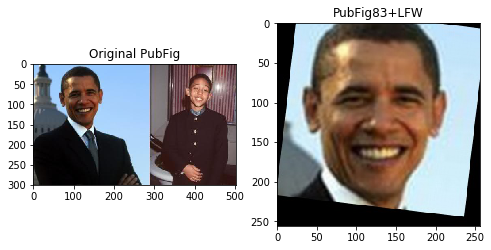

In [2]:
fig, ax = plt.subplots(1,2, figsize=(8,8)) 
img_before = plt.imread('BarackObama447.jpg')
img_after = plt.imread('train_000007-000129.jpg')
print('                      Barack Obama')
ax[0].imshow(img_before)
ax[0].set_title('Original PubFig')

ax[1].imshow(img_after)
ax[1].set_title('PubFig83+LFW');

### 1.2 Exploratory Data Analysis

The shape of each picture in PubFig is:

In [3]:
img_after.shape

(256, 256, 3)

Then we will take a look at the basic statistic summary of this dataset:

In [12]:
all_images_path = glob.glob('pf83_fixed/*.jpg')

In [13]:
mask = [path.split('/')[1].split('_')[0] != 'distract' for path in all_images_path]

images_path = np.array(all_images_path)[mask]

response_path = [path.split('/')[-1].split('.')[0].split('-')[0].split('_')[-1] for path in images_path]

name_append = list(Counter(response_path).keys())
count_append = list(Counter(response_path).values())

order_dict = dict(zip(name_append, count_append))
dict1 = sorted(order_dict.items())

name_list = []
count_list = []
for k,v in dict1:
    name_list.append(k)
    count_list.append(v)

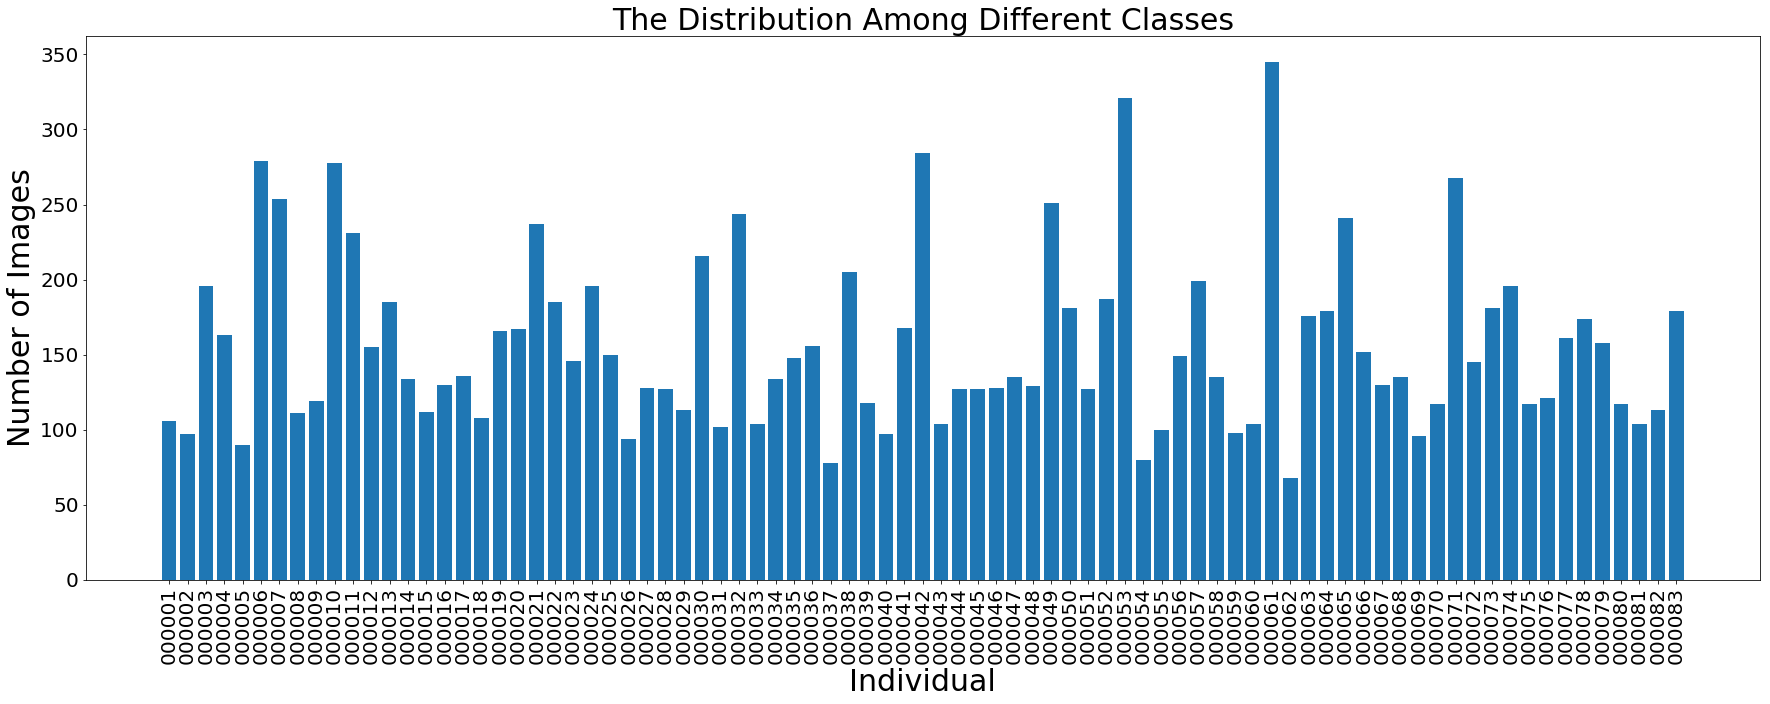

In [14]:
plt.figure(figsize = (30,10))
plt.bar(name_list, count_list)
plt.tick_params(labelsize=20)
pl.xticks(rotation=90)
plt.xlabel('Individual',fontsize = 30)
plt.ylabel('Number of Images', fontsize = 30)
plt.title('The Distribution Among Different Classes',fontsize = 30);

From the plot above we can see that, the data is imbalanced among classes to some extent. To make the distribution more balanced, we will only keep the individual which has more than 100 images and also down-sample the class with too many images(let's say 250 images).



### 1.3 Data Balancing

Only keep those with more than 100 images:

In [15]:
name_to_keep = np.array(name_list)[np.array(count_list)>100]
print('There will be {} classes left.'.format(np.sum(np.array(count_list)>100)))

There will be 73 classes left.


In [16]:
mask = []
for name_i in response_path:
    if name_i in name_to_keep:
        mask.append(True)
    else: mask.append(False)

image_path_sample = np.array(images_path)[mask]
response_path_sample = np.array(response_path)[mask]

print('There will be {} observations left.'.format(len(response_path_sample)))

There will be 12104 observations left.


In [17]:
response_path_sample = [path.split('/')[-1].split('.')[0].split('-')[0].split('_')[-1] for path in image_path_sample]

name_append_sample = list(Counter(response_path_sample).keys())
count_append_sample = list(Counter(response_path_sample).values())

order_dict_sample = dict(zip(name_append_sample, count_append_sample))
dict1_sample = sorted(order_dict_sample.items())

name_list_sample = []
count_list_sample = []
for k,v in dict1_sample:
    name_list_sample.append(k)
    count_list_sample.append(v)

Down-sample those with more than 250 images to 250:

In [18]:
name_down_sample= np.array(name_list_sample)[np.array(count_list_sample)>250]
print('There will be {} classes needed to down-sample.'.format(np.sum(np.array(count_list_sample)>250)))

There will be 8 classes needed to down-sample.


In [19]:
dict_down_sample = {'000006': [],'000007': [],'000010': [],'000042': [],
                    '000049': [],'000053': [],'000061': [],'000071': []}
for index_i, name_i in enumerate(response_path_sample):
    if name_i in name_down_sample:
        dict_down_sample[name_i].append(index_i)

In [20]:
np.random.seed(2019)
index_drop_list = []
for name_i in name_down_sample:
    index_drop = np.random.choice(dict_down_sample[name_i], len(dict_down_sample[name_i])-250, replace = False)
    index_drop_list += list(index_drop)   

mask_drop = np.ones(len(response_path_sample), dtype = bool)
mask_drop[index_drop_list] = False

image_path_sample = image_path_sample[mask_drop]
response_path_sample = np.array(response_path_sample)[mask_drop]

In [21]:
name_append_sample = list(Counter(response_path_sample).keys())
count_append_sample = list(Counter(response_path_sample).values())

order_dict_sample = dict(zip(name_append_sample, count_append_sample))
dict1_sample = sorted(order_dict_sample.items())

name_list_sample = []
count_list_sample = []
for k,v in dict1_sample:
    name_list_sample.append(k)
    count_list_sample.append(v)

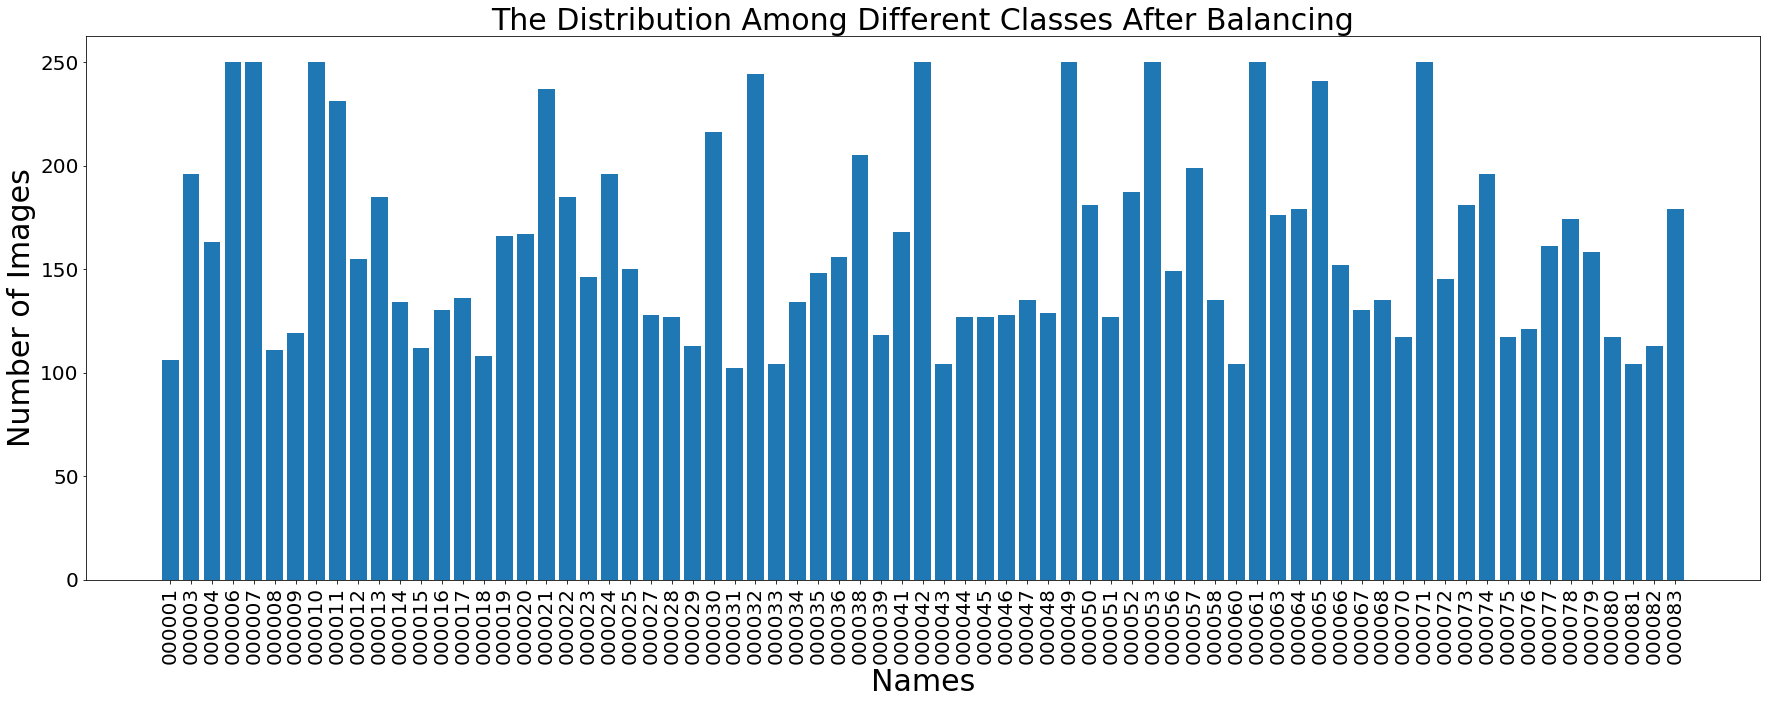

In [22]:
plt.figure(figsize = (30,10))
plt.bar(name_list_sample, count_list_sample)
plt.tick_params(labelsize=20)
pl.xticks(rotation=90)
plt.xlabel('Names',fontsize = 30)
plt.ylabel('Number of Images', fontsize = 30)
plt.title('The Distribution Among Different Classes After Balancing',fontsize = 30);

From the plot we can see that the sample is now more balanced.

## 2. Model Preparation

### 2.1 Processing features and response

In [23]:
# Parameters
BATCH_SIZE = 16
HEIGHT = 256
WIDTH = 256

We will resize the image to a uniform size; also, we will normalize the image to make the network converge faster. 

In [24]:
X_norm = np.empty(shape = (len(image_path_sample), HEIGHT, WIDTH, 3))
for i, file in enumerate(image_path_sample):
    img = imread(file)
    img = imresize(img, (HEIGHT, WIDTH)) 
    img = img.astype(np.float32) / 255.
    X_norm[i] = img

Do one-hot encoding for the response variable:

In [25]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(response_path_sample)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(-1, 1)
y_encoded = onehot_encoder.fit_transform(integer_encoded)


In [26]:
label_name_list = label_encoder.classes_

### 2.2 Train, Test, Validation Split

In our case of training the CNN, we will use cross-validation to evaluate the preformance.

Before feeding the data into our neural net, we split our data into train, test and validation set. To be specific, we will train and evaluate the model respectively on training set and validation set each epoch; At the end, we compare the performance of each model with its performance on test set. Also, we will keep track of the history of the performance on training and validation set each epoch to see if there is a severe overfitting problem.

In [27]:
X_TRAIN, X_test, Y_TRAIN,  y_test = train_test_split(X_norm, y_encoded, test_size = 0.1, random_state = 2019)
X_train, X_val, y_train,  y_val = train_test_split(X_TRAIN, Y_TRAIN, test_size = 0.2, random_state = 2019)

print('# Training Images: {}'.format(len(X_train)))
print('# Validation Images: {}'.format(len(X_val)))
print('# Test Images: {}'.format(len(X_test)))


# Training Images: 8512
# Validation Images: 2129
# Test Images: 1183


## 3. Modeling

During the modeling process, we will first build our own Baseline Convolutional Neural Network, and then conduct transfer learning on the state-of-the-art models.

In [28]:
# Parameters
INPUT_SHAPE = (256,256,3)
OUTPUT_SHAPE = np.sum(np.array(count_list)>100)
EPOCHS = 50

### 3.1 Baseline CNN

In [20]:
inp = Input(shape = INPUT_SHAPE)

model_1 = Conv2D(32, 3, 3, activation = 'relu', name = 'conv2d_1')(inp)
model_1 = MaxPooling2D(pool_size=(2, 2), name = 'max_pooling2d_1')(model_1)


model_1 = Conv2D(32, 3, 3, activation = 'relu',name = 'conv2d_2')(model_1)
model_1 = MaxPooling2D(pool_size=(2, 2),name = 'max_pooling2d_2')(model_1)

model_1 = Conv2D(64, 3, 3, activation = 'relu',name = 'conv2d_3')(model_1)
model_1 = Conv2D(128, 3, 3, activation = 'relu',name = 'conv2d_4')(model_1)
model_1 = MaxPooling2D(pool_size=(2, 2),name = 'max_pooling2d_3')(model_1)

model_1 = Flatten(name = 'flatten')(model_1)
model_1 = Dense(64, activation = 'relu',name = 'dense_1')(model_1)
model_1 = Dropout(0.3, name = 'dropout_1')(model_1)
out = Dense(OUTPUT_SHAPE, activation = 'softmax',name = 'output_layer')(model_1)

model_CNN = Model(inputs = inp, outputs = out) 

model_CNN.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


model_CNN.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)    

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", name="conv2d_1")`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", name="conv2d_2")`
  import sys
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="conv2d_3")`
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="conv2d_4")`


In [30]:
model_1_history = model_CNN.fit(X_train, y_train, batch_size= BATCH_SIZE, 
                                  epochs=EPOCHS,validation_data = (X_val, y_val),verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 8512 samples, validate on 2129 samples
Epoch 1/50
8512/8512 [==============================] - 48s 6ms/step - loss: 4.2782 - acc: 0.0236 - val_loss: 4.2207 - val_acc: 0.0366
Epoch 2/50
8512/8512 [==============================] - 39s 5ms/step - loss: 3.6775 - acc: 0.1114 - val_loss: 2.9787 - val_acc: 0.2607
Epoch 3/50
8512/8512 [==============================] - 39s 5ms/step - loss: 2.6610 - acc: 0.3119 - val_loss: 2.2650 - val_acc: 0.4298
Epoch 4/50
8512/8512 [==============================] - 39s 5ms/step - loss: 2.0673 - acc: 0.4409 - val_loss: 1.9432 - val_acc: 0.5021
Epoch 5/50
8512/8512 [==============================] - 39s 5ms/step - loss: 1.6256 - acc: 0.5324 - val_loss: 1.8398 - val_acc: 0.5223
Epoch 6/50
8512/8512 [==============================] - 39s 5ms/step - loss: 1.3656 - acc: 0.6044 - val_loss: 1.8031 - val_acc: 0.5420
Epoch 7/50
8512/8512 [==============================] - 39s 5ms/step - loss: 1.0774 - acc: 0.6

In [40]:
model_CNN.save('weight/model_1_3.h5')

In [21]:
def plot_learning(model_history, model_name):
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    ax[0].plot(model_history.history['acc'], 'r',label='Train')
    ax[0].plot(model_history.history['val_acc'], 'b' ,label='Val')
    ax[0].set_xlabel(r'Epoch', fontsize=10)
    ax[0].set_ylabel(r'Accuracy', fontsize=10)
    ax[0].set_title(r'Performance of {}'.format(model_name), fontsize=10)
    ax[0].legend()
    ax[0].tick_params(labelsize=10)

    ax[1].plot(model_history.history['loss'], 'r',label='Train')
    ax[1].plot(model_history.history['val_loss'], 'b' ,label='Val')
    ax[1].set_xlabel(r'Epoch', fontsize=10)
    ax[1].set_ylabel(r'Loss', fontsize=10)
    ax[1].set_title(r'Performance of {}'.format(model_name), fontsize=10)
    ax[1].legend()
    ax[1].tick_params(labelsize=10);


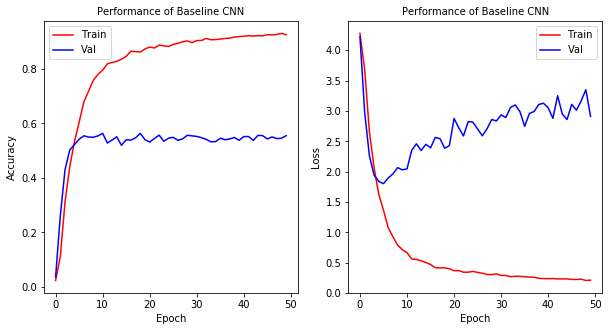

In [33]:
plot_learning(model_1_history, 'Baseline CNN')

In [34]:
print('The Accuracy for test set on CNN:{0:6.4f}'.format(model_CNN_1.evaluate(X_test,y_test,verbose=0)[1]))
        

The Accuracy for test set on CNN:0.5427


It seems that the model does not perform pretty well as the network is not deep enough to catch sufficient information. However, blindly increasing the depth of the network will also induce gradient degradation.

### 3.2 GoogleNet (Inception V3)

Here we use the transfer learning. Since the dataset is large and different from the original dataset (i.e. the imageNet), we can use the pre-trained network weights as initializers and train the network on the existing structure.

In [24]:
model_GN = applications.InceptionV3(weights = 'imagenet', 
                                  include_top = False,
                                  input_shape = INPUT_SHAPE)

model_GN.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 127, 127, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 127, 127, 32) 0           batch_normalization_1[0][0]      
_____________________________________

In [25]:
x = model_GN.output
x = Flatten()(x)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation = 'relu')(x)
output_GN = Dense(OUTPUT_SHAPE, activation = 'softmax')(x)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [32]:
Inception.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 127, 127, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 127, 127, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [26]:
Inception = Model(input = model_GN.input, output = output_GN)
Inception.compile(loss = "categorical_crossentropy", optimizer = SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

In [27]:
Inception_history = Inception.fit(X_train, y_train, batch_size= BATCH_SIZE, 
                                  epochs=EPOCHS,validation_data = (X_val, y_val),verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 8512 samples, validate on 2129 samples
Epoch 1/50
8512/8512 [==============================] - 217s 25ms/step - loss: 4.2531 - acc: 0.0375 - val_loss: 3.8859 - val_acc: 0.0968
Epoch 2/50
8512/8512 [==============================] - 202s 24ms/step - loss: 3.6723 - acc: 0.1205 - val_loss: 3.2535 - val_acc: 0.2039
Epoch 3/50
8512/8512 [==============================] - 202s 24ms/step - loss: 3.0151 - acc: 0.2414 - val_loss: 2.6356 - val_acc: 0.3260
Epoch 4/50
8512/8512 [==============================] - 201s 24ms/step - loss: 2.3636 - acc: 0.3871 - val_loss: 2.1365 - val_acc: 0.4415
Epoch 5/50
8512/8512 [==============================] - 201s 24ms/step - loss: 1.7818 - acc: 0.5221 - val_loss: 1.7506 - val_acc: 0.5397
Epoch 6/50
8512/8512 [==============================] - 201s 24ms/step - loss: 1.2962 - acc: 0.6500 - val_loss: 1.4872 - val_acc: 0.6106
Epoch 7/50
8512/8512 [==============================] - 201s 24ms/step - loss: 0.9

In [28]:
Inception.save('weight/Inception_1.h5')

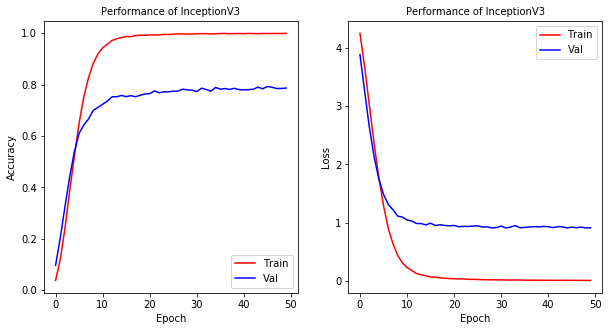

In [31]:
plot_learning(Inception_history, 'InceptionV3')

In [33]:
print('The Accuracy for test set on Inception:{0:6.4f}'.format(Inception.evaluate(X_test,y_test,verbose=0)[1]))
        

The Accuracy for test set on Inception:0.8107


### 3.3 VGG-19

In [52]:
model_vgg = applications.VGG19(weights = 'imagenet', 
                               include_top = False,
                               input_shape = INPUT_SHAPE)

80142336/80134624 [==============================] - 1s 0us/step


In [37]:
model_vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [38]:
x = model_vgg.output
x = Flatten()(x)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation = 'relu')(x)
output_vgg = Dense(OUTPUT_SHAPE, name = 'output')(x)
output_vgg = Activation('softmax',name = 'softmax')(output_vgg)

In [39]:
vgg = Model(input = model_vgg.input, output = output_vgg)
vgg.compile(loss = "categorical_crossentropy", optimizer = SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

In [40]:
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [68]:
vgg_history = vgg.fit(X_train, y_train, batch_size= BATCH_SIZE, 
                      epochs=EPOCHS,validation_data = (X_val, y_val),verbose=1)

Train on 8512 samples, validate on 2129 samples
Epoch 1/50
8512/8512 [==============================] - 305s 36ms/step - loss: 4.2777 - acc: 0.0262 - val_loss: 4.1142 - val_acc: 0.0700
Epoch 2/50
8512/8512 [==============================] - 298s 35ms/step - loss: 3.8775 - acc: 0.0842 - val_loss: 3.2908 - val_acc: 0.2029
Epoch 3/50
8512/8512 [==============================] - 298s 35ms/step - loss: 3.1313 - acc: 0.2274 - val_loss: 2.4741 - val_acc: 0.3744
Epoch 4/50
8512/8512 [==============================] - 298s 35ms/step - loss: 2.3233 - acc: 0.3947 - val_loss: 1.6720 - val_acc: 0.5552
Epoch 5/50
8512/8512 [==============================] - 298s 35ms/step - loss: 1.6893 - acc: 0.5430 - val_loss: 1.4175 - val_acc: 0.6303
Epoch 6/50
8512/8512 [==============================] - 298s 35ms/step - loss: 1.2292 - acc: 0.6559 - val_loss: 1.0285 - val_acc: 0.7201
Epoch 7/50
8512/8512 [==============================] - 298s 35ms/step - loss: 0.8601 - acc: 0.7525 - val_loss: 0.8837 - val_acc: 

In [69]:
vgg.save('weight/vgg_1.h5')

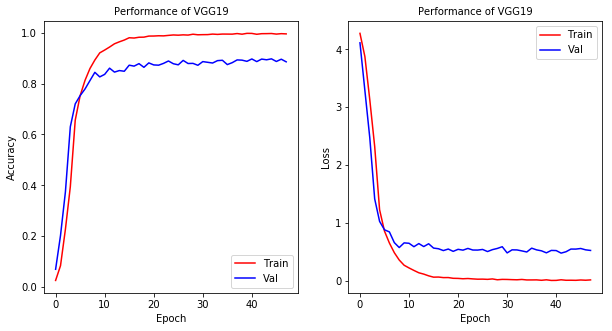

In [35]:
plot_learning(vgg_history, 'VGG19')

In [55]:
vgg = load_model('weight_new/vgg_2.h5')

In [46]:
print('The Accuracy for test set on VGG:{0:6.4f}'.format(vgg.evaluate(X_test,y_test,verbose=0)[1]))
        

The Accuracy for test set on VGG:0.8681


### 3.4 ResNet

In [22]:
model_RN = applications.ResNet50(weights = 'imagenet', 
                                  include_top = False,
                                  input_shape = INPUT_SHAPE)

model_RN.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
_____________________________________

In [23]:
x = model_RN.output
x = Flatten()(x)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation = 'relu')(x)
output_RN = Dense(OUTPUT_SHAPE, activation = 'softmax')(x)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [24]:
ResNet = Model(input = model_RN.input, output = output_RN)
ResNet.compile(loss = "categorical_crossentropy", optimizer = SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

In [29]:
ResNet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [25]:
ResNet_history = ResNet.fit(X_train, y_train, batch_size= BATCH_SIZE, epochs=EPOCHS,validation_data = (X_val, y_val),verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 8512 samples, validate on 2129 samples
Epoch 1/50
8512/8512 [==============================] - 295s 35ms/step - loss: 4.0151 - acc: 0.0969 - val_loss: 2.8379 - val_acc: 0.3109
Epoch 2/50
8512/8512 [==============================] - 284s 33ms/step - loss: 2.2769 - acc: 0.4145 - val_loss: 1.7624 - val_acc: 0.5538
Epoch 3/50
8512/8512 [==============================] - 284s 33ms/step - loss: 1.1491 - acc: 0.6833 - val_loss: 1.2826 - val_acc: 0.6703
Epoch 4/50
8512/8512 [==============================] - 284s 33ms/step - loss: 0.5570 - acc: 0.8489 - val_loss: 1.2257 - val_acc: 0.6839
Epoch 5/50
8512/8512 [==============================] - 284s 33ms/step - loss: 0.2888 - acc: 0.9214 - val_loss: 0.9320 - val_acc: 0.7567
Epoch 6/50
8512/8512 [==============================] - 284s 33ms/step - loss: 0.1593 - acc: 0.9639 - val_loss: 0.9323 - val_acc: 0.7586
Epoch 7/50
8512/8512 [==============================] - 284s 33ms/step - loss: 0.1

In [26]:
ResNet.save('weight/ResNet_1.h5')

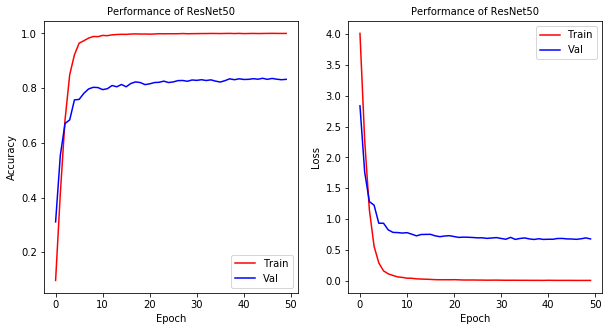

In [27]:
plot_learning(ResNet_history, 'ResNet50')

In [28]:
print('The Accuracy for test set on ResNet:{0:6.4f}'.format(ResNet.evaluate(X_test,y_test,verbose=0)[1]))


The Accuracy for test set on ResNet:0.8242


### 3.5 Model Comparison

From the test accuracy and also the learning process we can see that, VGG-19 gets the best performance in terms of the test accuracy. We can also see from its learning process that the model learns stable and does not seem to have a severe problem of overfitting. Inception-V3 and ResNet-50 also achieves a pretty good result on the test accuracy, and the learning processes are also very stable. 
 
Our baseline model has a quite poor performance comparing to the other three. Those state-of-the-art models greatly improves the model performance from our baseline model by increasing the depth, shrinking the filter size and using the module (also the bottleneck structure). Those designs can not only increase the accuracy, but also decrease the computational complexity. 


In [20]:
vgg = load_model('weight_new/vgg_2.h5')
resNet = load_model('weight_new/ResNet_2.h5')
cnn = load_model('weight_new/model_1_3.h5')
inception = load_model('weight_new/Inception_2.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


## 4. Attack Methods

### 4.1 Saliency Maps and Fast Gradient Methods(FGM)
{Using this model, we will compute class saliency maps as described in Section 3.1 of [2].

A **saliency map** tells us the degree to which each pixel in the image affects the classification score for that image. To compute it, we compute the gradient of the unnormalized score corresponding to the correct class (which is a scalar) with respect to the pixels of the image. If the image has shape `(H, W, 3)` then this gradient will also have shape `(H, W, 3)`; for each pixel in the image, this gradient tells us the amount by which the classification score will change if the pixel changes by a small amount. To compute the saliency map, we take the absolute value of this gradient, then take the maximum value over the 3 input channels; the final saliency map thus has shape `(H, W)` and all entries are nonnegative.

You will need to use the `model.classifier` Tensor containing the scores for each input, and will need to feed in values for the `model.image` and `model.labels` placeholder when evaluating the gradient. Open the file `deeplearning/classifiers/squeezenet.py` and read the documentation to make sure you understand how to use the model. For example usage, you can see the `loss` attribute. 

[2] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014.}

**Fast Gradient Method**:

$$X^{adv} = X + \epsilon \dfrac{\nabla_X J(X,y_{true})}{||\nabla_X J(X,y_{true})||_2}$$

$J$: loss function. Here we use the gradient from saliency maps ($-\nabla_X S_i$), where $S_i$ is the ith score(suppose true label = i) that's going to feed into the softmax activation layer in the last layer of our network

In [21]:
def compute_saliency_maps(X, y, model):

    outputTensor = model.get_layer('output').output
    correct_scores = tf.gather_nd(outputTensor,
                                      tf.stack((tf.range(X.shape[0]), np.argmax(y, axis=1)), axis=1))
    listOfVariableTensors = model.inputs[0]
    gradients = K.gradients(correct_scores, listOfVariableTensors)
    evaluated_gradients = sess.run(gradients,feed_dict={model.input:X, model.targets[0]:y})[0]
    
    saliency = np.max(np.abs(evaluated_gradients), axis=3)
    
    return saliency

In [23]:
sample_size = 7
X_sample = X_train[:sample_size]
y_sample = y_train[:sample_size]
saliency = compute_saliency_maps(X_sample, y_sample, vgg)

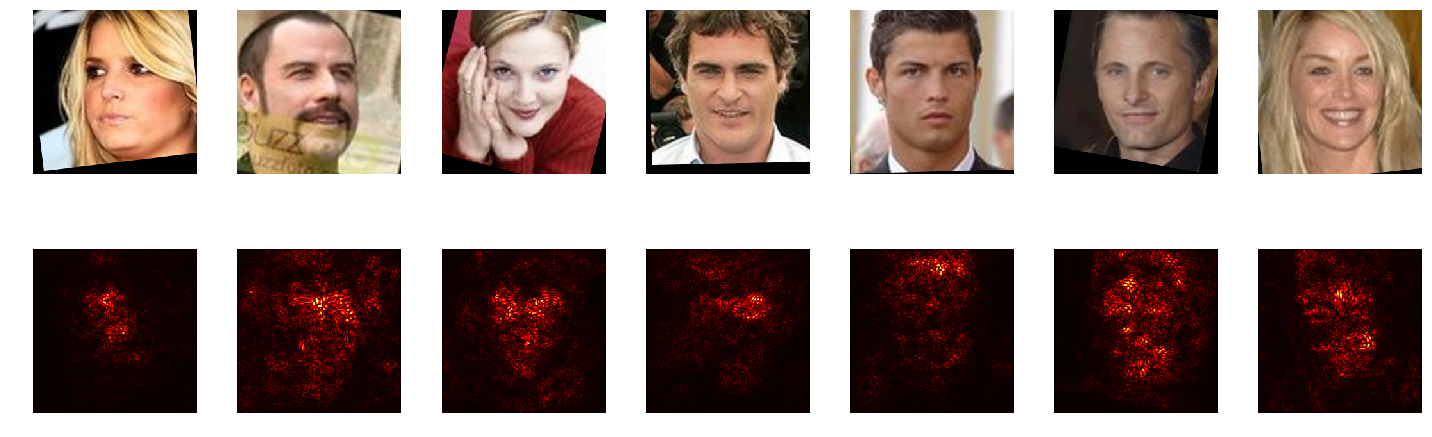

In [93]:
plt.figure(figsize=(20, 7))
for i in range(sample_size):
    plt.subplot(2, sample_size, i + 1)
    plt.imshow(X_sample[i])
    plt.axis('off')
    #plt.title(class_names[ym[i]])
    plt.subplot(2, sample_size, sample_size + i + 1)
    #plt.title(mask[i])
    plt.imshow(saliency[i], cmap=plt.cm.hot)
    plt.axis('off')
    # plt.gcf().set_size_inches(10, 2)
plt.tight_layout()
plt.show()

In [25]:
## https://arxiv.org/pdf/1312.6199.pdf
def FGM(X, y, model, eps=1):
    """
    Fast Gradient Sign Method
    Return the fooling image
    """
    X_fooling = X.copy()
    
    label = np.argmax(y, axis=1)
    print("target score: " + str(label))

    values = {model.input:X_fooling, model.targets[0]:y}
    
    outputTensor = None
    try:
        outputTensor = model.get_layer('output').output
    except:
        outputTensor = model.get_layer('output_layer').output
    
    all_classified_scores = sess.run(outputTensor, feed_dict=values)
    classified_score = np.argmax(all_classified_scores, axis=1)
    print("classified score: " + str(classified_score))
            
    if (classified_score != label).any():
        print("There's invalid example because the model makes a wrong prediction")
    
#     for t in range(100):
    correct_scores = tf.gather_nd(outputTensor,
                                  tf.stack((tf.range(X_fooling.shape[0]), np.argmax(y, axis=1)), axis=1))
    gradients = K.gradients(correct_scores, model.input)
    
#     loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels = y,logits = outputTensor)
#     gradients = K.gradients(loss, model.input)

    dX = sess.run(gradients, feed_dict={model.input:X_fooling})[0]

    norms = np.sqrt(np.sum(np.square(np.linalg.norm(dX,axis = (1,2))),axis = 1))
    X_fooling -= eps * dX / norms.reshape(-1,1,1,1)
    X_fooling = np.clip(X_fooling, 0, 1)
    values[model.input] = X_fooling


    all_classified_scores = sess.run(model.output, feed_dict=values)
    classified_score = np.argmax(all_classified_scores, axis=1)

#     print("t: " + str(t))
    print("classified score: " + str(classified_score))
    print("target score: " + str(label))
    
#         if classified_score != label:
#             return (X_fooling, classified_score)
        
    return (X_fooling, classified_score)


In [63]:
def plot_FGM(model, index_list, eps = 1):
    X = X_train[index_list]
    y = y_train[index_list]
    X_fooling, classified_score = FGM(X, y, model, eps)
    
    # Get the confidence of X and X_fooling
    outputTensor = model.output
    correct_scores = tf.gather_nd(outputTensor,
                              tf.stack((tf.range(X.shape[0]), np.argmax(y, axis=1)), axis=1))
    X_confidence = sess.run(correct_scores, feed_dict={model.input:X})
    
    correct_scores = tf.gather_nd(outputTensor,
                              tf.stack((tf.range(X_fooling.shape[0]), classified_score), axis=1))  
    X_fooling_confidence = sess.run(correct_scores, feed_dict={model.input:X_fooling})
    
    for i in range(len(X_fooling)):
        plt.figure(figsize=(12,7))
        plt.subplot(1, 4, 1)
        plt.imshow(X[i])
        plt.axis('off')
        plt.title("true class: " + label_name_list[np.argmax(y, axis=1)[i]] + \
                  "\n" + "confidence: " + str(X_confidence[i]))
        plt.subplot(1, 4, 2)
        plt.imshow(X_fooling[i])
        plt.title("predicted class: " + label_name_list[classified_score[i]] + \
                  "\n" + "confidence: " + str(X_fooling_confidence[i]))
        plt.axis('off')
        plt.subplot(1, 4, 3)
        plt.title('Difference')
        plt.imshow(X[i]-X_fooling[i])
        plt.axis('off') 
        plt.subplot(1, 4, 4)
        plt.title('Magnified difference (100x)')
        plt.imshow(100 * (X[i]-X_fooling[i]))
        plt.axis('off')
        plt.gcf().tight_layout()

target score: [70]
classified score: [70]
classified score: [46]
target score: [70]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


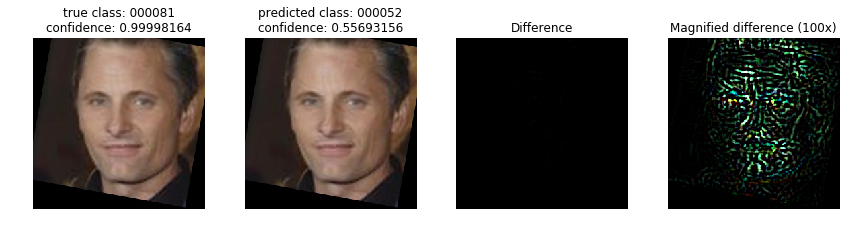

In [64]:
plot_FGM(vgg, [5])

In [24]:
def batch_FGM(X_train, y_train, model, batch=64, eps = 1):
    N = X_train.shape[0]
    success_count = 0
    X_fooling = np.zeros(X_train.shape)
    for i in range(0, N, batch):
        print("Fooling batch " + str(i))
        j = np.minimum(N-1, i + batch)
        X_train_batch, y_train_batch = X_train[i:j], y_train[i:j]
        X_fooling_batch, classified_batch = FGM(X_train_batch, y_train_batch, model, eps = eps)
        success_count += np.sum((classified_batch != np.argmax(y_train_batch, axis=1)).astype(int))
        X_fooling[i:j] = X_fooling_batch
        
    print("Percentage of successful attacks:")
    print(float(success_count) / float(N))
    
    return X_fooling

In [168]:
X_fooling_vgg = batch_FGM(X_test, y_test, vgg, batch=64, eps=1)

Fooling batch 0
target score: [30  6 43  2 29 69 53 43 30 52  2  7 19  3 62 14 56 46 53 44 66 72 72 71
 52  2 57 19 26 67 55 11 15 44 52 36 48 63 39 10  2 65 42  0 43 43  9 56
 36 70 10  1 13 33 30 18 19 20 24 36 70 42 61 22]
classified score: [30 34 68  2 34 41 53 43 32 52  2  7 19  3 62 14 56 46 53 44 66 72 72 71
 52 52 57 19 37 67 55 11 15 44 52 36 58 50 72 10  2  4 42  0 43 43  9 22
 36 70 33  1 13 33 32 18 19 20 63 36 32 33 61 22]
There's invalid example because the model makes a wrong prediction
classified score: [19 34 68 28 39 21 33 17 32 52 57 39  7  3 62 14 57 58 21 22 31 72 72 71
 52 54 33 19 31 38  5 35 30 52 52 36 58 50 72 68 63  4 50 67 35  8  7  8
 36 46 33  1 38  8 32 18  5 51 63 43 28  1 61 44]
target score: [30  6 43  2 29 69 53 43 30 52  2  7 19  3 62 14 56 46 53 44 66 72 72 71
 52  2 57 19 26 67 55 11 15 44 52 36 48 63 39 10  2 65 42  0 43 43  9 56
 36 70 10  1 13 33 30 18 19 20 24 36 70 42 61 22]
Fooling batch 64
target score: [30 43  1 23 35 24 55 44 66  8 25 46  

classified score: [53 61 67 68 21 55 49  7 59 72 37  3 12 24 61 19 44  8 23 42 72  3 43 41
 45 68 33  7 68 18 68  1 53 33 66 14 72  1 69 27 33 48  2 11 56 36 36 61
  8 46  7 64 48 65 20 51 20 10 51 68 24  7 61 41]
There's invalid example because the model makes a wrong prediction
classified score: [11 61 13  3 63 46 49 30 38 42 32 25 39 21  1 19 68  8 23 42 72 10 28  8
 45  3 33 21 62 18 68  1 10 33 66 14 72  1 69 55 33 30 33 72 56  3 39 61
 36 47 19 64  7 65 45 51  7  8 58 10 52 14 61 41]
target score: [53 61 67 68 46 55 49  7  2 72 37  3 12 24 61  8 44  8 23 42 72  3 43 41
 45 68 33  7 68 18 47 20 53 33 66 14 46 11 69 27 33 48  2 11 56 36 36 61
  8 46  5 64 30 65 20 51 20 49 51 40 24  7 61 41]
Fooling batch 640
target score: [60 32 20 28  9 60 33 58 47 28 54 53 36 63 39 32 66 30  8  5 67 44 10 10
 21 65 11 13 62  1 33 54 67 13  2  0 60  8  3 67 39 61 33 25 10 14 38 45
 54 25 66  4 10 46 34 44 19 52 19  8 37 65 37 54]
classified score: [60 32 20 28  9 60 33 58 47 28 54 53 36 63 11 32 

classified score: [68 10  4 41 21 20 72 24 45 23 14 72 11  4 36 29 26 69 17 44 19 25  0 43
 44 18 72 24 45  3]
There's invalid example because the model makes a wrong prediction
classified score: [68 10  4 68 21 20 72 52 17 23 14 72 60  4  6  1 14 11 17 52 52 42 19 35
 57 18 70 24 51 72]
target score: [40 68  4 69 21 20 72 24 55 23 14 72 11  4 36 29 26 69 17 44 19 25  0 43
 44 18 72 24 46  3]
Percentage of successful attacks:
0.6754015215553677


In [27]:
X_fooling_resNet = batch_FGM(X_test, y_test, resNet, batch=32, eps=1)

Fooling batch 0
target score: [30  6 43  2 29 69 53 43 30 52  2  7 19  3 62 14 56 46 53 44 66 72 72 71
 52  2 57 19 26 67 55 11]
classified score: [30  6 40  2 29 29 28 43 30 52  2 38 19  3 62 14 56 46 53 44 66 72 72 71
 52  2  2 19 26 13 55 11]
There's invalid example because the model makes a wrong prediction
classified score: [34 29 10 10 39 55 28 62 17 65 44 38  8 25 62 51 67 21 63 60 30  8 52 71
 14 51 62 48 29 13  5 52]
target score: [30  6 43  2 29 69 53 43 30 52  2  7 19  3 62 14 56 46 53 44 66 72 72 71
 52  2 57 19 26 67 55 11]
Fooling batch 32
target score: [15 44 52 36 48 63 39 10  2 65 42  0 43 43  9 56 36 70 10  1 13 33 30 18
 19 20 24 36 70 42 61 22]
classified score: [15 44 52 36 48 63 72 36  2 65 40  0 43 43 57  2 36 41  3  1  5 33  7 18
 19 20 24 36 70 44 61 22]
There's invalid example because the model makes a wrong prediction
classified score: [30  1 44 25  5 56 72 36 63  7 53 70 28  2 42 67 12 43 41 44 38 62  7 72
 30 55 30  2 59  3 38  1]
target score: [15 44 52 36

classified score: [11 10 13 25 34  3 61 14 43 50 33 44 32 63 35 34 63 36 14 72  7  6 34 28
 23 21 62  0 54 13  9 49]
There's invalid example because the model makes a wrong prediction
classified score: [72 51  0 62 24 33 38 55 42 64 33 44 65 28 35 25 63  9 28 35 18 71 21 36
 23 52 10  0  8 45  2 47]
target score: [11 10 13 25 34  3 61  7 43 50  1 42 32 63 29 34 53 36 14 72 67  6 34 28
 23 21 62  5 54 13  9 49]
Fooling batch 512
target score: [52 26 62 69 32 49  0 31 20 66 21 53 67 66 18 60 53 52  8 28 67 51  4 42
 69 56 41 37 47  8 33 65]
classified score: [52 26 62 51 32 49 61 31 20 66 21  4 67 66 18 60 53 52  8 28  8 51  4 42
 47 56 41 37 47 28 33 65]
There's invalid example because the model makes a wrong prediction
classified score: [35 30 57 51 26 36 61 72 30  5 21  4 48 13 26  8  8 30 56 19 38 30 38 50
 30 47 40 20 35 52 33 66]
target score: [52 26 62 69 32 49  0 31 20 66 21 53 67 66 18 60 53 52  8 28 67 51  4 42
 69 56 41 37 47  8 33 65]
Fooling batch 544
target score: [43 43 26

classified score: [26 64 33 64 52  7 42 17 71 22 42 30 45 16 38  7 70 38 30 49 30 62 44 56
 18 21 46 55 65 71 67 58]
target score: [13 65  3 45 36 37 44 13 19 28 53 26 30  7 67 33 49  5  8 22 71 28 58 36
 18 21 57 57 32 71 72 26]
Fooling batch 992
target score: [ 7 32 28  0 49 12 19 52 62 43 54 46 60 15 52 42 50  8 15  6 25 33 54  7
 69 52 67 11 63 53 52 17]
classified score: [ 7 32 28  0 49 49 19 34 62 43 29 46 60 15 52 42 49  8 15  6 25 26 54 19
 69 52 67 11 63 53 52 17]
There's invalid example because the model makes a wrong prediction
classified score: [13  0 50  4 22 49 19 34 39 50 18  4 28 51 59  8  8 68  7 56 28 26  9 59
 29 35 38 47 62 52 22 26]
target score: [ 7 32 28  0 49 12 19 52 62 43 54 46 60 15 52 42 50  8 15  6 25 33 54  7
 69 52 67 11 63 53 52 17]
Fooling batch 1024
target score: [72 65 69 35  5 49 41  7  6 62 71 49 25 34 69 35 35 30 52 10 20 26  8 42
 32 68 72 25 31 34 67 10]
classified score: [72 65 69 35  5 72 41 37  6 62 71 49 25 62 69 35 35  7 52 10 20 26  8 42
 3

In [37]:
X_fooling_inception = batch_FGM(X_test, y_test, inception, batch=64, eps=1)

Fooling batch 0
target score: [30  6 43  2 29 69 53 43 30 52  2  7 19  3 62 14 56 46 53 44 66 72 72 71
 52  2 57 19 26 67 55 11 15 44 52 36 48 63 39 10  2 65 42  0 43 43  9 56
 36 70 10  1 13 33 30 18 19 20 24 36 70 42 61 22]
classified score: [30  1 43  2 60 41 12 43 30 52  2  7 19  3 62 14 56 46 53 44 66 72 72 71
 52 62  2 19 26 58 55 11 15 44 52 36 48 63 29 10  2 65 42  0 68 43  9  7
 36 45 10  1 38 33 17 18 19 20 24 36 17  3 61 22]
There's invalid example because the model makes a wrong prediction
classified score: [35  3 50 47 43 52 54 52 30 12 24 18 26 47 42  4 43 46 63 60 30 54 10 58
 21 29 62 58 34 55 61 52 17 35 10 25 35 56 44 68 50 38  9 26  6  8 42  7
 12 41 21  9 39 21 66 15 66 17 10 43 43  3 61 11]
target score: [30  6 43  2 29 69 53 43 30 52  2  7 19  3 62 14 56 46 53 44 66 72 72 71
 52  2 57 19 26 67 55 11 15 44 52 36 48 63 39 10  2 65 42  0 43 43  9 56
 36 70 10  1 13 33 30 18 19 20 24 36 70 42 61 22]
Fooling batch 64
target score: [30 43  1 23 35 24 55 44 66  8 25 46  

classified score: [53 61 67 68 46 55 49 70 59 72 37  3 12 24 61 19 44  8 23 42 72 54 43 41
 45  9 33  7 68 18 68 20 53 33 66 14 48 10 69 27 33 48  2 11 56  3 36 61
  8 46 46 64 17 65 20 51 31 54 45 10 24  7 61 41]
There's invalid example because the model makes a wrong prediction
classified score: [11 29  5 18 39 16 39 51 20  7 38 39 22 56 31 23 42 54 64  2 72 39 53 43
 64 49 33 15 10  4 70 31 10 33 14 50 49 10 41 58 68  7  7 72 48  3 62 44
 68 61 51 19 55 15 70  5 55 35 61 17 42  5 21  3]
target score: [53 61 67 68 46 55 49  7  2 72 37  3 12 24 61  8 44  8 23 42 72  3 43 41
 45 68 33  7 68 18 47 20 53 33 66 14 46 11 69 27 33 48  2 11 56 36 36 61
  8 46  5 64 30 65 20 51 20 49 51 40 24  7 61 41]
Fooling batch 640
target score: [60 32 20 28  9 60 33 58 47 28 54 53 36 63 39 32 66 30  8  5 67 44 10 10
 21 65 11 13 62  1 33 54 67 13  2  0 60  8  3 67 39 61 33 25 10 14 38 45
 54 25 66  4 10 46 34 44 19 52 19  8 37 65 37 54]
classified score: [60 32 20 28  9 60 33 58  3 28 54 53 22 63 39 32 

classified score: [40 68  4 41 21 20 72 24 45 23 14 72 11  4 36 34 26 69 17 44 19 25  0 43
 44 18 72 24 46  3]
There's invalid example because the model makes a wrong prediction
classified score: [ 9 10 58 60 47 32 44 12 20 23 71 72 49 66 68  4  7 18 20  1 30 39 71 58
  9 70 70 68  7 10]
target score: [40 68  4 69 21 20 72 24 55 23 14 72 11  4 36 29 26 69 17 44 19 25  0 43
 44 18 72 24 46  3]
Percentage of successful attacks:
0.9408284023668639


In [25]:
X_fooling_cnn = batch_FGM(X_test, y_test, cnn, batch=64, eps=1)

Fooling batch 0
target score: [30  6 43  2 29 69 53 43 30 52  2  7 19  3 62 14 56 46 53 44 66 72 72 71
 52  2 57 19 26 67 55 11 15 44 52 36 48 63 39 10  2 65 42  0 43 43  9 56
 36 70 10  1 13 33 30 18 19 20 24 36 70 42 61 22]
classified score: [30  8 47 10 29 68 17  9 38 63  2  7 19 36 62 14 43 46 53 60 66 72 72 71
 21  6  2 19 58 67 55 11  0 47 52 36 53 43 29 10  2 65 44  0 68 56  1 69
 36 28  9  1 13 33 39 18 19 20 52 36 45 34 38 41]
There's invalid example because the model makes a wrong prediction
classified score: [ 9 10 47 54 44 68 32 47 38 15 52 61  7 36 60 14 43 46 53 60 70 55 18 71
 21  6  2 19 58 66 38 54  0 47 44 10 53 43 29  8 50 66 44 26 68 56  1 69
 58 28  9  6 66 21 39 18 55  5 63 28 45 34 38 41]
target score: [30  6 43  2 29 69 53 43 30 52  2  7 19  3 62 14 56 46 53 44 66 72 72 71
 52  2 57 19 26 67 55 11 15 44 52 36 48 63 39 10  2 65 42  0 43 43  9 56
 36 70 10  1 13 33 30 18 19 20 24 36 70 42 61 22]
Fooling batch 64
target score: [30 43  1 23 35 24 55 44 66  8 25 46  

classified score: [28 67 38  1  9  7 53 68 29 61  7 55 50 72 44  3 47 28 23 63 18 10 57 43
 53 43 33 37 54 55  3  7 68 21 66  4 63 67 28 26  9 30 39 18 43 44 36 15
 38 21 48 26  3 58 45 70 70  2 48 30 33 46 26 56]
target score: [53 61 67 68 46 55 49  7  2 72 37  3 12 24 61  8 44  8 23 42 72  3 43 41
 45 68 33  7 68 18 47 20 53 33 66 14 46 11 69 27 33 48  2 11 56 36 36 61
  8 46  5 64 30 65 20 51 20 49 51 40 24  7 61 41]
Fooling batch 640
target score: [60 32 20 28  9 60 33 58 47 28 54 53 36 63 39 32 66 30  8  5 67 44 10 10
 21 65 11 13 62  1 33 54 67 13  2  0 60  8  3 67 39 61 33 25 10 14 38 45
 54 25 66  4 10 46 34 44 19 52 19  8 37 65 37 54]
classified score: [60 32 18 28  9 36 33 53 56 28 54 47 60 60 52 32 66 30 44 23  5 44 34 43
 21 65 11 13  8  1 33 11 67 13  2  7 60  8  3 67 59 61 33 36 54 20 66 51
 54 10 66  4 35  9 43 47 19 52 19  8 37 65 55 54]
There's invalid example because the model makes a wrong prediction
classified score: [22 70 18 28  8 36 33 53  3 68 54 47 60 26 52 70 

classified score: [ 8 19 66 36 47 20 31 50 23 23 20 72  8 31 43 60  7  3 45 47 68 39 55 35
 39 18 72 34 55 28]
target score: [40 68  4 69 21 20 72 24 55 23 14 72 11  4 36 29 26 69 17 44 19 25  0 43
 44 18 72 24 46  3]
Percentage of successful attacks:
0.9146238377007607


### 4.2 Fast Gradient Sign Methods(FGSM)

$X^{adv} = X + \epsilon \textrm{sign}\{\nabla_X J(X,y_{true})\}$

$J$: loss function. Cross-entropy between $f(x)$, the output of the softmax layer, i.e. probability vector and true one-hot label.

In [65]:
def FGSM(X, y, model, eps = 0.02):
    """
    Fast Gradient Sign Method
    Return the fooling image
    """
    X_fooling = X.copy()
#     eps = 0.02

    label = np.argmax(y, axis=1)
    print("ground truth class: " + str(label))

    values = {model.input:X_fooling, model.targets[0]:y}

    outputTensor = None
    try:
        outputTensor = model.get_layer('output').output
    except:
        outputTensor = model.get_layer('output_layer').output

    all_classified_scores = sess.run(outputTensor, feed_dict=values)
    classified_score = np.argmax(all_classified_scores, axis=1)
    print("classified class: " + str(classified_score))

    if (classified_score != label).any():
        print("Invalid example exits where the model makes a wrong prediction")
    #     return (X_fooling, classified_score)

    loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels = y,logits = outputTensor)
    gradients = K.gradients(loss, model.input)

    dX = sess.run(gradients, feed_dict={model.input:X_fooling})[0] #shape(?,64,64,3)

    # update X_fooling using gradient sign with step eps
    X_fooling += eps * np.sign(dX)
    # clipping in the original paper: [X-e,X+e]&[0,1] we don't have hyper-param e here
    X_fooling = np.clip(X_fooling,0,1)
    values[model.input] = X_fooling

    all_classified_scores = sess.run(model.output, feed_dict=values)
    classified_score = np.argmax(all_classified_scores, axis=1)

#     print("t: " + str(t))
    print("Classified: " + str(classified_score))
    print("Ground truth: " + str(label))

#         if (classified_score != label).all():
#             return (X_fooling, classified_score)

    return (X_fooling, classified_score)

In [66]:
def plot_FGSM(model, index_list):
    X = X_train[index_list]
    y = y_train[index_list]
    X_fooling, classified_score = FGSM(X, y, model)  
               
    # Get the confidence of X and X_fooling
    outputTensor = model.output
    correct_scores = tf.gather_nd(outputTensor,
                              tf.stack((tf.range(X.shape[0]), np.argmax(y, axis=1)), axis=1))
    X_confidence = sess.run(correct_scores, feed_dict={model.input:X})
    
    correct_scores = tf.gather_nd(outputTensor,
                              tf.stack((tf.range(X_fooling.shape[0]), classified_score), axis=1))  
    X_fooling_confidence = sess.run(correct_scores, feed_dict={model.input:X_fooling})
    
    for i in range(len(X_fooling)):
        plt.figure(figsize=(12,7))
        plt.subplot(1, 4, 1)
        plt.imshow(X[i])
        plt.axis('off')
        plt.title("true class: " + label_name_list[np.argmax(y, axis=1)[i]] + \
                  "\n" + "confidence: " + str(X_confidence[i]))
        plt.subplot(1, 4, 2)
        plt.imshow(X_fooling[i])
        plt.title("predicted class: " + label_name_list[classified_score[i]] + \
                  "\n" + "confidence: " + str(X_fooling_confidence[i]))
        plt.axis('off')
        plt.subplot(1, 4, 3)
        plt.title('Difference')
        plt.imshow(X[i]-X_fooling[i])
        plt.axis('off') 
        plt.subplot(1, 4, 4)
        plt.title('Magnified difference (100x)')
        plt.imshow(100 * (X[i]-X_fooling[i]))
        plt.axis('off')
        plt.gcf().tight_layout()

ground truth class: [70]
classified class: [70]
Classified: [39]
Ground truth: [70]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


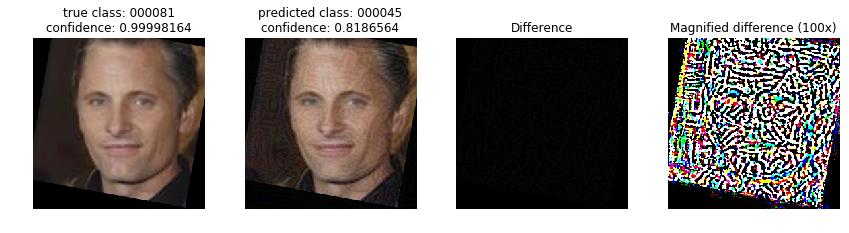

In [67]:
plot_FGSM(vgg, [5])

In [22]:
def batch_FGSM(X_train, y_train, model, batch=64, eps = 0.01):
    N = X_train.shape[0]
    correct_count = 0
    X_fooling = np.zeros(X_train.shape)
    for i in range(0, N, batch):
        print("Fooling batch " + str(i))
        j = np.minimum(N-1, i + batch)
        X_train_batch, y_train_batch = X_train[i:j], y_train[i:j]
        X_fooling_batch, classified_batch = FGSM(X_train_batch, y_train_batch, model, eps = eps)
        correct_count += np.sum((classified_batch != np.argmax(y_train_batch, axis=1)).astype(int))
        X_fooling[i:j] = X_fooling_batch
        
    print("Percentage of successful attacks:")
    print(float(correct_count) / float(N))

    return X_fooling

In [35]:
X_fooling_vgg_FGSM = batch_FGSM(X_test, y_test, vgg, batch=64, eps = 0.01)

Fooling batch 0
ground truth class: [30  6 43  2 29 69 53 43 30 52  2  7 19  3 62 14 56 46 53 44 66 72 72 71
 52  2 57 19 26 67 55 11 15 44 52 36 48 63 39 10  2 65 42  0 43 43  9 56
 36 70 10  1 13 33 30 18 19 20 24 36 70 42 61 22]
classified class: [30 34 68  2 34 41 53 43 32 52  2  7 19  3 62 14 56 46 53 44 66 72 72 71
 52 52 57 19 37 67 55 11 15 44 52 36 58 50 72 10  2  4 42  0 43 43  9 22
 36 70 33  1 13 33 32 18 19 20 63 36 32 33 61 22]
Invalid example exits where the model makes a wrong prediction
Classified: [19 34 68 28 39 41 33 60 32 52 57 31  7 49 62 14 57 58 63 60 67 72 72 71
 33 52 33 30 31 38  0 35 45 52 24 62 58 50 72 68 63  4 50 38 35  8  7  8
 57 32 33 10 38  8 32 72 67 32 63 43 45 33 67 56]
Ground truth: [30  6 43  2 29 69 53 43 30 52  2  7 19  3 62 14 56 46 53 44 66 72 72 71
 52  2 57 19 26 67 55 11 15 44 52 36 48 63 39 10  2 65 42  0 43 43  9 56
 36 70 10  1 13 33 30 18 19 20 24 36 70 42 61 22]
Fooling batch 64
ground truth class: [30 43  1 23 35 24 55 44 66  8 25 46

classified class: [53 61 67 68 21 55 49  7 59 72 37  3 12 24 61 19 44  8 23 42 72  3 43 41
 45 68 33  7 68 18 68  1 53 33 66 14 72  1 69 27 33 48  2 11 56 36 36 61
  8 46  7 64 48 65 20 51 20 10 51 68 24  7 61 41]
Invalid example exits where the model makes a wrong prediction
Classified: [ 1 20 13 60 63 58 31 30 38 33 32 25 10 21 16 19 68 57 64 60 72 10 36 36
 15 36 33 21 62 72 68  1 10 33 66  7 72  1 41 26  8 30 33 72  9  3 43 61
 62  7 19 45  7  5 32 45  7 10 45 68 47 14 16 68]
Ground truth: [53 61 67 68 46 55 49  7  2 72 37  3 12 24 61  8 44  8 23 42 72  3 43 41
 45 68 33  7 68 18 47 20 53 33 66 14 46 11 69 27 33 48  2 11 56 36 36 61
  8 46  5 64 30 65 20 51 20 49 51 40 24  7 61 41]
Fooling batch 640
ground truth class: [60 32 20 28  9 60 33 58 47 28 54 53 36 63 39 32 66 30  8  5 67 44 10 10
 21 65 11 13 62  1 33 54 67 13  2  0 60  8  3 67 39 61 33 25 10 14 38 45
 54 25 66  4 10 46 34 44 19 52 19  8 37 65 37 54]
classified class: [60 32 20 28  9 60 33 58 47 28 54 53 36 63 11 32 66 3

classified class: [68 10  4 41 21 20 72 24 45 23 14 72 11  4 36 29 26 69 17 44 19 25  0 43
 44 18 72 24 45  3]
Invalid example exits where the model makes a wrong prediction
Classified: [68 10 14 41 47 20 69 52 45 23 70 72 10 23 43 42 14 35 45 52 28 57 38 35
 42 18 70  6 45 36]
Ground truth: [40 68  4 69 21 20 72 24 55 23 14 72 11  4 36 29 26 69 17 44 19 25  0 43
 44 18 72 24 46  3]
Percentage of successful attacks:
0.885883347421809


In [43]:
X_fooling_inception_FGSM = batch_FGSM(X_test, y_test, inception, batch=64, eps = 0.01)

Fooling batch 0
ground truth class: [30  6 43  2 29 69 53 43 30 52  2  7 19  3 62 14 56 46 53 44 66 72 72 71
 52  2 57 19 26 67 55 11 15 44 52 36 48 63 39 10  2 65 42  0 43 43  9 56
 36 70 10  1 13 33 30 18 19 20 24 36 70 42 61 22]
classified class: [30  1 43  2 60 41 12 43 30 52  2  7 19  3 62 14 56 46 53 44 66 72 72 71
 52 62  2 19 26 58 55 11 15 44 52 36 48 63 29 10  2 65 42  0 68 43  9  7
 36 45 10  1 38 33 17 18 19 20 24 36 17  3 61 22]
Invalid example exits where the model makes a wrong prediction
Classified: [38  1 40 25 60 52 36 22 32 65 43 35 26 62 42  7 43 46 63 60 48 54 10 58
 12 62  2  7 34 58 67 52 17  1 44 62 58 56 61 28 50 58  9 38 68  2 42  7
 33 58 48 44 38 47 17 72  7 45 47 43 17  3 61 11]
Ground truth: [30  6 43  2 29 69 53 43 30 52  2  7 19  3 62 14 56 46 53 44 66 72 72 71
 52  2 57 19 26 67 55 11 15 44 52 36 48 63 39 10  2 65 42  0 43 43  9 56
 36 70 10  1 13 33 30 18 19 20 24 36 70 42 61 22]
Fooling batch 64
ground truth class: [30 43  1 23 35 24 55 44 66  8 25 46

classified class: [53 61 67 68 46 55 49 70 59 72 37  3 12 24 61 19 44  8 23 42 72 54 43 41
 45  9 33  7 68 18 68 20 53 33 66 14 48 10 69 27 33 48  2 11 56  3 36 61
  8 46 46 64 17 65 20 51 31 54 45 10 24  7 61 41]
Invalid example exits where the model makes a wrong prediction
Classified: [11 44 58 39 39 16  9 51 20  7 48 52 22 21 66 19 42 54 64  8 72 54 53 68
 17  9 24  4 10 66 68 31 10 49 31 20 48 10 41 58 40  7 55 35 21  3 62 44
 68 20 65 45 17 15 31  5 58  6 45 10 34  5 21  3]
Ground truth: [53 61 67 68 46 55 49  7  2 72 37  3 12 24 61  8 44  8 23 42 72  3 43 41
 45 68 33  7 68 18 47 20 53 33 66 14 46 11 69 27 33 48  2 11 56 36 36 61
  8 46  5 64 30 65 20 51 20 49 51 40 24  7 61 41]
Fooling batch 640
ground truth class: [60 32 20 28  9 60 33 58 47 28 54 53 36 63 39 32 66 30  8  5 67 44 10 10
 21 65 11 13 62  1 33 54 67 13  2  0 60  8  3 67 39 61 33 25 10 14 38 45
 54 25 66  4 10 46 34 44 19 52 19  8 37 65 37 54]
classified class: [60 32 20 28  9 60 33 58  3 28 54 53 22 63 39 32 66 3

Classified: [ 9 10 71 41 47 32 18 12 45 23 33 72 56 66 35  4  7 29 45 11 30 12 71 35
 42 61 56 68 32 10]
Ground truth: [40 68  4 69 21 20 72 24 55 23 14 72 11  4 36 29 26 69 17 44 19 25  0 43
 44 18 72 24 46  3]
Percentage of successful attacks:
0.9721048182586645


In [25]:
X_fooling_resNet_FGSM = batch_FGSM(X_test, y_test, resNet, batch=32, eps = 0.01)

Fooling batch 0
ground truth class: [30  6 43  2 29 69 53 43 30 52  2  7 19  3 62 14 56 46 53 44 66 72 72 71
 52  2 57 19 26 67 55 11]
classified class: [30  6 40  2 29 29 28 43 30 52  2 38 19  3 62 14 56 46 53 44 66 72 72 71
 52  2  2 19 26 13 55 11]
Invalid example exits where the model makes a wrong prediction
Classified: [61  1 40 53 43 55 28  6 17 47 36 38 27 47 62 66 25 21 63 60 17 51 47 71
 24 62  2 16 61 13  5 35]
Ground truth: [30  6 43  2 29 69 53 43 30 52  2  7 19  3 62 14 56 46 53 44 66 72 72 71
 52  2 57 19 26 67 55 11]
Fooling batch 32
ground truth class: [15 44 52 36 48 63 39 10  2 65 42  0 43 43  9 56 36 70 10  1 13 33 30 18
 19 20 24 36 70 42 61 22]
classified class: [15 44 52 36 48 63 72 36  2 65 40  0 43 43 57  2 36 41  3  1  5 33  7 18
 19 20 24 36 70 44 61 22]
Invalid example exits where the model makes a wrong prediction
Classified: [30  1 44 36  5 49 72 36 63  7 40 38 50  2 42 67  2 41  3  9  5  2  7 72
 17 38 63  2 17  3 38 60]
Ground truth: [15 44 52 36 48 63 3

classified class: [11 10 13 25 34  3 61 14 43 50 33 44 32 63 35 34 63 36 14 72  7  6 34 28
 23 21 62  0 54 13  9 49]
Invalid example exits where the model makes a wrong prediction
Classified: [72 50 31 62 24 33 67 55 42 23 33 44 65  8 35 22 63  9 58 70 18 29 29 36
 23 52 40  0  8 48 33 63]
Ground truth: [11 10 13 25 34  3 61  7 43 50  1 42 32 63 29 34 53 36 14 72 67  6 34 28
 23 21 62  5 54 13  9 49]
Fooling batch 512
ground truth class: [52 26 62 69 32 49  0 31 20 66 21 53 67 66 18 60 53 52  8 28 67 51  4 42
 69 56 41 37 47  8 33 65]
classified class: [52 26 62 51 32 49 61 31 20 66 21  4 67 66 18 60 53 52  8 28  8 51  4 42
 47 56 41 37 47 28 33 65]
Invalid example exits where the model makes a wrong prediction
Classified: [35 30 57 51 26 36 61 72 30 37 47  4 66 13 39  8 28 33 21 43  8  7  4 33
 30 10 40 20 52 28 49 32]
Ground truth: [52 26 62 69 32 49  0 31 20 66 21 53 67 66 18 60 53 52  8 28 67 51  4 42
 69 56 41 37 47  8 33 65]
Fooling batch 544
ground truth class: [43 43 26 52 41 1

Classified: [20 64 33 19  2  7 63 66 38 22 42 30 45 16 38 18 49 38 28 40 30 62 18 41
 18 42 46 55 65 36 67 58]
Ground truth: [13 65  3 45 36 37 44 13 19 28 53 26 30  7 67 33 49  5  8 22 71 28 58 36
 18 21 57 57 32 71 72 26]
Fooling batch 992
ground truth class: [ 7 32 28  0 49 12 19 52 62 43 54 46 60 15 52 42 50  8 15  6 25 33 54  7
 69 52 67 11 63 53 52 17]
classified class: [ 7 32 28  0 49 49 19 34 62 43 29 46 60 15 52 42 49  8 15  6 25 26 54 19
 69 52 67 11 63 53 52 17]
Invalid example exits where the model makes a wrong prediction
Classified: [13 65 50  4  8 49 48 34 39 63 29  7 41 51 59  9  8 68  7 35 28 26 47 19
 29 35 66 47 47 52  2 26]
Ground truth: [ 7 32 28  0 49 12 19 52 62 43 54 46 60 15 52 42 50  8 15  6 25 33 54  7
 69 52 67 11 63 53 52 17]
Fooling batch 1024
ground truth class: [72 65 69 35  5 49 41  7  6 62 71 49 25 34 69 35 35 30 52 10 20 26  8 42
 32 68 72 25 31 34 67 10]
classified class: [72 65 69 35  5 72 41 37  6 62 71 49 25 62 69 35 35  7 52 10 20 26  8 42
 32 62

In [31]:
X_fooling_cnn = batch_FGSM(X_test, y_test, cnn, batch=64, eps=1)

Fooling batch 0
ground truth class: [30  6 43  2 29 69 53 43 30 52  2  7 19  3 62 14 56 46 53 44 66 72 72 71
 52  2 57 19 26 67 55 11 15 44 52 36 48 63 39 10  2 65 42  0 43 43  9 56
 36 70 10  1 13 33 30 18 19 20 24 36 70 42 61 22]
classified class: [30  8 47 10 29 68 17  9 38 63  2  7 19 36 62 14 43 46 53 60 66 72 72 71
 21  6  2 19 58 67 55 11  0 47 52 36 53 43 29 10  2 65 44  0 68 56  1 69
 36 28  9  1 13 33 39 18 19 20 52 36 45 34 38 41]
Invalid example exits where the model makes a wrong prediction
Classified: [39 70 47 39 39 68 29 58 39 61 37 67 48 34 39 67 36 47 39 68 56 39 68 61
  8 39 20 68 72 59 61 39 52 59 17 39 50 67  7 68 29  1 39 58  8 59  7 36
 18 50 65 68 39 68 39 72 65  8 39 39 18 69 29 39]
Ground truth: [30  6 43  2 29 69 53 43 30 52  2  7 19  3 62 14 56 46 53 44 66 72 72 71
 52  2 57 19 26 67 55 11 15 44 52 36 48 63 39 10  2 65 42  0 43 43  9 56
 36 70 10  1 13 33 30 18 19 20 24 36 70 42 61 22]
Fooling batch 64
ground truth class: [30 43  1 23 35 24 55 44 66  8 25 46

Classified: [ 7 67 60 55 52  4 55 46 59 52  4 71 18 42 52 20 39 52 39 52 51  7 50 39
 68 42 39 29 36 68  6  7 70 50 16 18  4 67 61 67 70 36  7 39 35 18 51 71
 21 39 39 49  1  4 56  8 70  7 68  7  5 72 59 18]
Ground truth: [53 61 67 68 46 55 49  7  2 72 37  3 12 24 61  8 44  8 23 42 72  3 43 41
 45 68 33  7 68 18 47 20 53 33 66 14 46 11 69 27 33 48  2 11 56 36 36 61
  8 46  5 64 30 65 20 51 20 49 51 40 24  7 61 41]
Fooling batch 640
ground truth class: [60 32 20 28  9 60 33 58 47 28 54 53 36 63 39 32 66 30  8  5 67 44 10 10
 21 65 11 13 62  1 33 54 67 13  2  0 60  8  3 67 39 61 33 25 10 14 38 45
 54 25 66  4 10 46 34 44 19 52 19  8 37 65 37 54]
classified class: [60 32 18 28  9 36 33 53 56 28 54 47 60 60 52 32 66 30 44 23  5 44 34 43
 21 65 11 13  8  1 33 11 67 13  2  7 60  8  3 67 59 61 33 36 54 20 66 51
 54 10 66  4 35  9 43 47 19 52 19  8 37 65 55 54]
Invalid example exits where the model makes a wrong prediction
Classified: [55  4 39 67 51 48  8 18 16 52 45 44  8  4 18 14 18 18 58  

### 4.3 Iterative Fast Gradient Sign Methods(I-FGSM)

$X^{adv}_{0} = X$
$X^{adv}_{N+1} = Clip_{X,\epsilon}\{X^{adv}_{N} + \alpha \textrm{sign}(\nabla_X J(X^{adv}_{N},y_{true}))\}$

$J$: loss function. Cross-entropy between $f(x)$, the output of the softmax layer, i.e. probability vector and true one-hot label.

$\alpha$: $\epsilon/k$, $k$ is the (maximum) number of iteration.

$Clip_{X,\epsilon}$: clip the value to be in $[X-\epsilon,X+\epsilon]$ and also $[0,1]$ since our pixel values are betwwen 0 and 1.

In [52]:
def IFGSM(X, y, model, max_iter = 10, alpha = 0.01):
    """
    Fast Gradient Sign Method
    Return the fooling image
    """
    X_fooling = X.copy()
    eps = alpha * max_iter

    label = np.argmax(y, axis=1)
    print("ground truth class: " + str(label))

    values = {model.input:X_fooling, model.targets[0]:y}

    outputTensor = None
    try:
        outputTensor = model.get_layer('output').output
    except:
        outputTensor = model.get_layer('output_layer').output

    all_classified_scores = sess.run(outputTensor, feed_dict=values)
    classified_score = np.argmax(all_classified_scores, axis=1)
    print("classified class: " + str(classified_score))

    if (classified_score != label).any():
        print("Invalid example exits where the model makes a wrong prediction")
    #     return (X_fooling, classified_score)

    for t in range(max_iter):

        loss = tf.nn.softmax_cross_entropy_with_logits(labels = y,logits = outputTensor)
        gradients = K.gradients(loss, model.input)

        dX = sess.run(gradients, feed_dict={model.input:X_fooling})[0] #shape(?,64,64,3)

        # update X_fooling using gradient sign with step eps
        X_fooling += alpha * np.sign(dX)
        X_fooling = np.clip(X_fooling,X-eps,X+eps)
        # clipping in the original paper: [X-e,X+e]&[0,1] e = eps*max_iter
        X_fooling = np.clip(X_fooling,0,1)
        values[model.input] = X_fooling

        all_classified_scores = sess.run(model.output, feed_dict=values)
        classified_score = np.argmax(all_classified_scores, axis=1)

        print("t: " + str(t))
        print("Classified: " + str(classified_score))
        print("Ground truth: " + str(label))

        if (classified_score != label).all():
            return (X_fooling, classified_score)

    return (X_fooling, classified_score)

In [68]:
def plot_IFGSM(model, index_list):
    X = X_train[index_list]
    y = y_train[index_list]
    X_fooling, classified_score = IFGSM(X, y, model)  
               
    # Get the confidence of X and X_fooling
    outputTensor = model.output
    correct_scores = tf.gather_nd(outputTensor,
                              tf.stack((tf.range(X.shape[0]), np.argmax(y, axis=1)), axis=1))
    X_confidence = sess.run(correct_scores, feed_dict={model.input:X})
    
    correct_scores = tf.gather_nd(outputTensor,
                              tf.stack((tf.range(X_fooling.shape[0]), classified_score), axis=1))  
    X_fooling_confidence = sess.run(correct_scores, feed_dict={model.input:X_fooling})
    
    for i in range(len(X_fooling)):
        plt.figure(figsize=(12,7))
        plt.subplot(1, 4, 1)
        plt.imshow(X[i])
        plt.axis('off')
        plt.title("true class: " + label_name_list[np.argmax(y, axis=1)[i]] + \
                  "\n" + "confidence: " + str(X_confidence[i]))
        plt.subplot(1, 4, 2)
        plt.imshow(X_fooling[i])
        plt.title("predicted class: " + label_name_list[classified_score[i]] + \
                  "\n" + "confidence: " + str(X_fooling_confidence[i]))
        plt.axis('off')
        plt.subplot(1, 4, 3)
        plt.title('Difference')
        plt.imshow(X[i]-X_fooling[i])
        plt.axis('off') 
        plt.subplot(1, 4, 4)
        plt.title('Magnified difference (100x)')
        plt.imshow(100 * (X[i]-X_fooling[i]))
        plt.axis('off')
        plt.gcf().tight_layout()

ground truth class: [70]
classified class: [70]
t: 0
Classified: [39]
Ground truth: [70]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


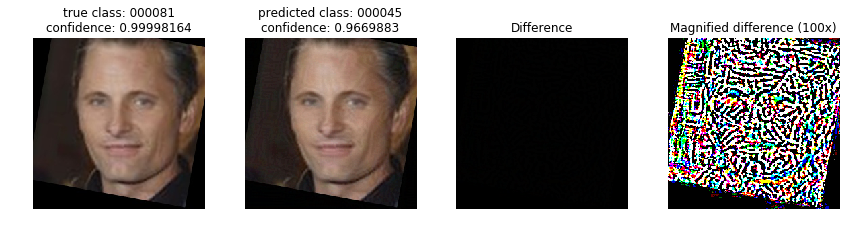

In [69]:
plot_IFGSM(vgg, [5])

In [35]:
def batch_IFGSM(X_train, y_train, model, batch=64, max_iter=5, alpha = 0.01):
    N = X_train.shape[0]
    correct_count = 0
    X_fooling = np.zeros(X_train.shape)
    for i in range(0, N, batch):
        print("Fooling batch " + str(i))
        j = np.minimum(N-1, i + batch)
        X_train_batch, y_train_batch = X_train[i:j], y_train[i:j]
        X_fooling_batch, classified_batch = IFGSM(X_train_batch, y_train_batch, model, max_iter = max_iter, alpha = alpha)
        correct_count += np.sum((classified_batch != np.argmax(y_train_batch, axis=1)).astype(int))
        X_fooling[i:j] = X_fooling_batch
        
    print("Percentage of successful attacks:")
    print(float(correct_count) / float(N))

    return X_fooling

In [40]:
X_fooling_vgg = batch_IFGSM(X_test, y_test, vgg, batch=64, max_iter=10, alpha = 0.001)

Fooling batch 0
ground truth class: [30  6 43  2 29 69 53 43 30 52  2  7 19  3 62 14 56 46 53 44 66 72 72 71
 52  2 57 19 26 67 55 11 15 44 52 36 48 63 39 10  2 65 42  0 43 43  9 56
 36 70 10  1 13 33 30 18 19 20 24 36 70 42 61 22]
classified class: [30 34 68  2 34 41 53 43 32 52  2  7 19  3 62 14 56 46 53 44 66 72 72 71
 52 52 57 19 37 67 55 11 15 44 52 36 58 50 72 10  2  4 42  0 43 43  9 22
 36 70 33  1 13 33 32 18 19 20 63 36 32 33 61 22]
Invalid example exits where the model makes a wrong prediction
t: 0
Classified: [19 34 68  2 34 41 33 60 32 52  2  7  7  3 62 14 56 46 63 44 66 72 72 71
 52 52 57 19 37 67  5 11 15 44 52 36 58 50 72 10  2  4 42  0 35 43  9  8
 36 70 33  1 38 33 32 18 67 20 63 36 45 33 61 22]
Ground truth: [30  6 43  2 29 69 53 43 30 52  2  7 19  3 62 14 56 46 53 44 66 72 72 71
 52  2 57 19 26 67 55 11 15 44 52 36 48 63 39 10  2 65 42  0 43 43  9 56
 36 70 10  1 13 33 30 18 19 20 24 36 70 42 61 22]
t: 1
Classified: [19 34 68 28 39 41 33 60 32 52  2 31  7  3 62 14 57

t: 7
Classified: [45 57 62 64 52 44  4 63 32  9 39 72  4 53 72 15 33  4 33 57 10 72 58 13
 28 28 52  1 10  3 55 72 67 29 61  9 23 52 68 22 58 52 37 21 21 37 58 50
 19  5 51 11 10  8 61 29  4 26  4 23  1 32 52 12]
Ground truth: [30 43  1 23 35 24 55 44 66  8 25 46  4 45 31 50 21 58 30 63 12 18  4 26
 50 36 63 39 24 12 14 68 38 10 16 28 17 47 43 28 48  1 26 47 24 66 41 40
  7 31 45 56 69 36 48 29  4 55 19  4 62 70  3 28]
t: 8
Classified: [45 57 62 64 52 44  4 63 32  9 39 72 23 53 72 15 33  4 33 57 10 72 58 13
 28 28 52  1 10  3 55 72 67 29 61  9 23 52 68 22 58 52 37 21 21 37 58 50
 19  5 51 11 10  8 61 29 48 26  4 23  1 32 52 12]
Ground truth: [30 43  1 23 35 24 55 44 66  8 25 46  4 45 31 50 21 58 30 63 12 18  4 26
 50 36 63 39 24 12 14 68 38 10 16 28 17 47 43 28 48  1 26 47 24 66 41 40
  7 31 45 56 69 36 48 29  4 55 19  4 62 70  3 28]
t: 9
Classified: [45 57 62 64 52 44  4 63 32  9 39 72 23 53 72 15 33  4 33 57 10 72 58 13
 28 28 52  1 10  3 55 72 67 29 61  9 23 52 68 22 58 52 37 21 21 

t: 5
Classified: [16  4  5 22 52 26 30 22 22 72 38 61 52 31 55 12 50  8 30 60 67 30  7 35
 42 52  3 37 67 50 68 33 35 42 47 16 68 43  9  0 63 19 68 28 14  2 45  8
  1 35 68  7 67 33 24 58 60  9 68 14 58  9  1  1]
Ground truth: [61 26 46 56  2 45 19 49 28 18 48 15  2 13  5 28 42  9 19 35 66 30 48 57
 16 35 33 66 58 48 43  8  9 63 52 16  9 36 22 13 18  8  3 36  4 28 51 68
 39 56 57 48 14 42 25 19 41 68 63 37 46  8 46 54]
t: 6
Classified: [16  4  5 22 52 26 30 22 22 72 38 61 52 31 55 12 50  8 30 60 67 30  7 35
 42 52  3 37 67 50 68 33 35 42 47 16 68 43  9  0 63 19 68 28 14  2 45  8
  1 35 68  7 67 33 24 58 60  9 68 14 58  9  1  1]
Ground truth: [61 26 46 56  2 45 19 49 28 18 48 15  2 13  5 28 42  9 19 35 66 30 48 57
 16 35 33 66 58 48 43  8  9 63 52 16  9 36 22 13 18  8  3 36  4 28 51 68
 39 56 57 48 14 42 25 19 41 68 63 37 46  8 46 54]
t: 7
Classified: [16  4  5 22 52 26 30 22 22 72 38 61 52 31 55 12 50  8 30 60 67 30  7 35
 42 52  3 37 67 50 68 33 35 42 47 72 68 43  9  0 63 19 68 28 14 

t: 5
Classified: [ 4 47  1  1 33 43  1 58 21 33 16 38 35 23 32  3 53 15  7 58 32 41 32 47
 26 46 33 19  4 63 11 21 47 26 24 13  6 19 57 52 10 31 60 17 42 26 67 34
 48 23 26 68 16 41  1  9 68 12 52 72  3 68 24 30]
Ground truth: [58 21 36 39 52 36 47 58 33  3 55 61 11  4 32 53 60 50 31 19 66 40 70 34
 65  7 52 72 19 36 40 39 54  7  8 14 62 32 53 25  1 37 53 20 53 27 66 29
 46 64 26 10 16  3 50 28 22 28  9 19  3 40 36 67]
t: 6
Classified: [ 4 47  1  1 33 43  1 58 21 33 16 38 35 23 32  3 53 15  7 58 32 41 32 47
 26 46 33 19  4 63 11 21 47 26 24 13  6 19 57 52 10 31 60 17 42 26 67 34
 48 23 27 68 16 41  1  9 68 12 52 72 69 68 24 30]
Ground truth: [58 21 36 39 52 36 47 58 33  3 55 61 11  4 32 53 60 50 31 19 66 40 70 34
 65  7 52 72 19 36 40 39 54  7  8 14 62 32 53 25  1 37 53 20 53 27 66 29
 46 64 26 10 16  3 50 28 22 28  9 19  3 40 36 67]
t: 7
Classified: [ 4 47  1  1 33 43  1 58 21 33 16 38 35 23 32  3 53 15  7 58 32 41 32 47
 26 46 33 19  4 63 11 21 47 26 24 13  6 19 57 52 10 31 60 17 42 

t: 2
Classified: [ 8 16 46 60 58 19 26 37 61 47 43 67 63 30 67 40  8 67 68 47 46 21 19 49
 50  8  5 67 67 52 43 35 10 10  0 62 44 33 38 14 10 50 33 44 32 68  2 68
 42 43 58 10 37  6  1  8 23 21 33  0 52 31 33 10]
Ground truth: [ 8 24 63 68 58 32 26 37 61  1 43 70 63 32 20  3 41 19 22 36 63 21 65 49
 53 34 31 30 67 54 10 59 11 10 13 25 34  3 61  7 43 50  1 42 32 63 29 34
 53 36 14 72 67  6 34 28 23 21 62  5 54 13  9 49]
t: 3
Classified: [68 16 46 60 58 19 26 37 61 47 43 67 63 30 67 40  8 67 68 47 46 68 19 49
 50  8  5 67 61 52 43 35 10  8  0 62 44 33 38 14 10 15 33 44 32 68  2 68
 42 43 58 10 37  6  1  8 23 47 33  0 52 31 33 10]
Ground truth: [ 8 24 63 68 58 32 26 37 61  1 43 70 63 32 20  3 41 19 22 36 63 21 65 49
 53 34 31 30 67 54 10 59 11 10 13 25 34  3 61  7 43 50  1 42 32 63 29 34
 53 36 14 72 67  6 34 28 23 21 62  5 54 13  9 49]
t: 4
Classified: [68 16 46 60 58 19 26 37 61 47 43 67 42 30 67 40  8 67 68 47 46 68 19 49
 50  8  5 67 61 52 43 35 10  8  0 62 44 33 38 14 10 15 33 44 66 

t: 2
Classified: [ 1 61 13 60 63 58 49 30 38 61 32 25 10 21 16 19 68  8 23 42 72 10 36 36
 15 35 33 21 62 18 68  1 53 33 66 14 72  1 69 27  8 30 33 72 56  3 43 61
 62  7  7 64  7 65 32 45  7 10 45 68 47 14 16 41]
Ground truth: [53 61 67 68 46 55 49  7  2 72 37  3 12 24 61  8 44  8 23 42 72  3 43 41
 45 68 33  7 68 18 47 20 53 33 66 14 46 11 69 27 33 48  2 11 56 36 36 61
  8 46  5 64 30 65 20 51 20 49 51 40 24  7 61 41]
t: 3
Classified: [ 1 20 13 60 63 58  7 30 38 61 32 25 10 21 16 19 68  8 23 60 72 10 36 36
 15 35 33 21 62 72 68  1 10 33 66 14 72  1 69 26  8 30 33 72  9  3 43 61
 62  7  7 45  7  5 32 45  7 10 45 68 47 14 16 68]
Ground truth: [53 61 67 68 46 55 49  7  2 72 37  3 12 24 61  8 44  8 23 42 72  3 43 41
 45 68 33  7 68 18 47 20 53 33 66 14 46 11 69 27 33 48  2 11 56 36 36 61
  8 46  5 64 30 65 20 51 20 49 51 40 24  7 61 41]
t: 4
Classified: [ 1 20 13 60 63 58  7 30 38 61 32 25 10 21 16 19 68  8 64 60 72 10 36 36
 15 35 33 21 62 72 68  1 10 33 66  7 72  1 41 26  8 30 33 72  9 

t: 2
Classified: [ 3 29 13 62 16 44 60 60 10 21 33  1  7 52 47 34 54  3 39 23 37 44  1 33
  1 50 19 45 10 10 51 30  7 71 58 68 36 37 61 60 10 10  9 52 68 33 49 66
 37  7 51 28 64 53 68 32  1 26 63 42  4 26 29  0]
Ground truth: [ 3 29 17  6 16 44 42 28 10 44 47  1 46 52 54  8 54  3 43 17 37 24 39 62
 69 10  5 33 69  1 49 19 14 71 55 41 36 55 61 41  9  1 49 47 28 40 49 66
 72  7 32 43 23 50 63 65 10 26 63 60  4 26 59 52]
t: 3
Classified: [ 3 35 13 62 16 44 60 60 10 21 33  1  7 35 47 34 54  3 39 23 37 44  1 33
  1 50 19 45 10 10 51 30  7 68 58 68 36 37 61 60 10 10  9 52 68 33 49 66
 37  7 51 28 64 53 68 32  1 72 63 42  4 26 29  0]
Ground truth: [ 3 29 17  6 16 44 42 28 10 44 47  1 46 52 54  8 54  3 43 17 37 24 39 62
 69 10  5 33 69  1 49 19 14 71 55 41 36 55 61 41  9  1 49 47 28 40 49 66
 72  7 32 43 23 50 63 65 10 26 63 60  4 26 59 52]
t: 4
Classified: [ 3 35 13 62 16 44 60 60 39 21 33  1  7 35 47 34 52  3 39 23 37 44  1 33
  1 50 19 45 10 10 51 30  7 68 58 68 36 37 67 60 10 10  9 52 68 

classified class: [31  4 55 28 47 18  3 12  5 18 62 30  8  8 27 58 27  1 10  1 58 32 36 53
 41  1 36 24 57 36 34 33 40 26 20 53 23 35 67 22 45 64 50 68  8 28 67 35
 19 17 33 46 25 61 21  3 39 32 33 72  8 19 27 66]
Invalid example exits where the model makes a wrong prediction
t: 0
Classified: [31  4 55 28 47 45  3 36 31 18  1 67  8 10 27 58 27  1 10  1 58 32 36 10
 41  1 36 24 57 36 34 33 40 26 55 53 45 35 67 22 45 64 50 68  8 28 67 35
 19 17 33 46 25 61 21  3 39 32 33 72  8 48 30 66]
Ground truth: [31  4 55 28 47 18  3 12  5 18 62 30  8  8 27 58 27  1 10  1 58 17 36 53
 41 40 36  6 57 36 34 33 40 26 20 22 23 29 67 22 45 64 50  1  8 28 67 35
 19 17 33 46 25 61 21  3 39 32 33 72  8 19 27 66]
t: 1
Classified: [70  4 16 28 47 45  3 36 31 18  1 67  8 10 33 58 27  1  1 60 58 32 47 10
 68  1 36 24 42 36 52 33 40 26 55 53 45 35 67 22 45 64 50 68 50  9  7 35
 32 17  3 46 25 61 21  3 10 32 33 72  8 48 30 66]
Ground truth: [31  4 55 28 47 18  3 12  5 18 62 30  8  8 27 58 27  1 10  1 58 17 36 53


classified class: [13 65  3 45 28 37 60 13 19 28 53 26 30  7 67 33 49  5  8 22 71 28 72 36
 18 21 57 53 32 71 72 26  7 32 68  0 49 12 19 47 52 43 54 46 60 15 52 42
 50  8 15  6 25  8 54  7 69 52 67 11 63 53 52 17]
Invalid example exits where the model makes a wrong prediction
t: 0
Classified: [13 65  3 45 28 37 60 13  4 28 53 26 32  7 67 33 49  5 28 22 13 28 72 36
 18 21 57 53 32 71 72 26  7 38 68  0 49 12 19 47 52 68 47 46 60 15 52  8
 60  8 15  6 25  8 54  7 69 52 67 11 63 53 60 17]
Ground truth: [13 65  3 45 36 37 44 13 19 28 53 26 30  7 67 33 49  5  8 22 71 28 58 36
 18 21 57 57 32 71 72 26  7 32 28  0 49 12 19 52 62 43 54 46 60 15 52 42
 50  8 15  6 25 33 54  7 69 52 67 11 63 53 52 17]
t: 1
Classified: [13 65  3 48 28 37 60 13  4 28 53 26 32  4 24 33 49  5 28  1 13 28 72 36
 61 21 57 53 32 71 72 26  7 38 68  0 49 47 19 47 52 68 47 46 57 15 52  8
 60  8 15 29 36  8 47 65 69 52 67 11 63 53 60 17]
Ground truth: [13 65  3 45 36 37 44 13 19 28 53 26 30  7 67 33 49  5  8 22 71 28 58 36


classified class: [26 27 12 69 47 36 65 52 11 57 38 37 55 26 14 32 28 71  0 43 46 46 46 43
 48 45 61  5 27 68 37 60  8 61  0 11  8 38  4 26 31  1  1 48  9  3 33 38
 14 21 24 72 28 46 20 11 57 26 22 71 46  4 43  8]
Invalid example exits where the model makes a wrong prediction
t: 0
Classified: [26 27 12 69 57 36 65 52 11 57 13 37 55 26 14 32 28 71  0 43  7 46 46 43
 58 45 61  5 27 60 37 10  8 61 66 11  8 38  4 26 31  1  1 48 33  3 33 38
 14 21 24 72 28 46 20 11 57 26 22 71 57  4 43  8]
Ground truth: [26 27 12 69 47 36 65 52 11 57 38 52 55 26 14 32 28 71 31 43 46 46 46 43
 48 45 61  5 27 68 37 60  8 61  0 11 33 38 71 26 31  1  1 48  9  3 33 38
 14 21 24 72 28 46 20 56 57 26 22 71 46  4 43  8]
t: 1
Classified: [26 27 12 11 57 36 65 52 11 57 13 37 67 26 14 66 28 71  0 43  7  5 46 36
 58 15 61  7 27 60 37 10  8 61 66 11  8  4  4 26  0  1  1  7 33  3 33 38
 14 21 33 72 28 46 20 10 42 13 22 71 57  4 43 63]
Ground truth: [26 27 12 69 47 36 65 52 11 57 38 52 55 26 14 32 28 71 31 43 46 46 46 43


In [48]:
X_fooling_inception = batch_IFGSM(X_test[:256], y_test[:256], inception, batch=64, max_iter=5, alpha = 0.002)

Fooling batch 0
ground truth class: [30  6 43  2 29 69 53 43 30 52  2  7 19  3 62 14 56 46 53 44 66 72 72 71
 52  2 57 19 26 67 55 11 15 44 52 36 48 63 39 10  2 65 42  0 43 43  9 56
 36 70 10  1 13 33 30 18 19 20 24 36 70 42 61 22]
classified class: [30  1 43  2 60 41 12 43 30 52  2  7 19  3 62 14 56 46 53 44 66 72 72 71
 52 62  2 19 26 58 55 11 15 44 52 36 48 63 29 10  2 65 42  0 68 43  9  7
 36 45 10  1 38 33 17 18 19 20 24 36 17  3 61 22]
Invalid example exits where the model makes a wrong prediction
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

t: 0
Classified: [28  1 40 25 60 52 36 22 32 47 24 18 26 62 42  7 43 46 63 60 65 10 10 58
 21 62  2  7 34 58 61 52 17  1 44 47 58 56 61 68 50 38  9 38 68  2 42  7
 34 58 42 44 38 47 17 72  7 70 47 43 17  3 61 11]
Ground truth: [30  6 43  2 29 69 53 43 30 52  2  7 19  3 62 14 56 46 53 44 66 72 72 71


In [29]:
X_fooling_resNet_IFGSM = batch_IFGSM(X_test[:256], y_test[:256], resNet, batch=32, max_iter=5, alpha = 0.002)

Fooling batch 0
ground truth class: [30  6 43  2 29 69 53 43 30 52  2  7 19  3 62 14 56 46 53 44 66 72 72 71
 52  2 57 19 26 67 55 11]
classified class: [30  6 40  2 29 29 28 43 30 52  2 38 19  3 62 14 56 46 53 44 66 72 72 71
 52  2  2 19 26 13 55 11]
Invalid example exits where the model makes a wrong prediction
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

t: 0
Classified: [61  1 40 10 43 29 28  6 17 47 36 38 27 47 62 66 63  7 63 60 17 72 47 71
 24 41  2 16 61 13  5 35]
Ground truth: [30  6 43  2 29 69 53 43 30 52  2  7 19  3 62 14 56 46 53 44 66 72 72 71
 52  2 57 19 26 67 55 11]
t: 1
Classified: [61  1 40 12 43 55 28  6 17 47 36 38 27 47 53 66 67  7 63 60 17  7 47 58
  8 41  2 16 61 13  5 35]
Ground truth: [30  6 43  2 29 69 53 43 30 52  2  7 19  3 62 14 56 46 53 44 66 72 72 71
 52  2 57 19 26 67 55 11]
Fooling batch 32
ground truth class:

In [36]:
X_fooling_cnn = batch_IFGSM(X_test[:256], y_test[:256], cnn, batch=32, max_iter=5, alpha = 0.002)

Fooling batch 0
ground truth class: [30  6 43  2 29 69 53 43 30 52  2  7 19  3 62 14 56 46 53 44 66 72 72 71
 52  2 57 19 26 67 55 11]
classified class: [30  8 47 10 29 68 17  9 38 63  2  7 19 36 62 14 43 46 53 60 66 72 72 71
 21  6  2 19 58 67 55 11]
Invalid example exits where the model makes a wrong prediction
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

t: 0
Classified: [33  8 47 54 44 68 32 47 38 63 52  0  7 36 62 14 43 46 53 60 39 55 18 71
 21  6  2 19 58 66 38 54]
Ground truth: [30  6 43  2 29 69 53 43 30 52  2  7 19  3 62 14 56 46 53 44 66 72 72 71
 52  2 57 19 26 67 55 11]
t: 1
Classified: [33  8 47 54 44 68 32 47 38 63 52 61  7 36 60 66 43 21 63 60 39 55 18 71
 21  6  2 17 58 66 38 54]
Ground truth: [30  6 43  2 29 69 53 43 30 52  2  7 19  3 62 14 56 46 53 44 66 72 72 71
 52  2 57 19 26 67 55 11]
t: 2
Classified: [33  8 47 54 44 68 

t: 1
Classified: [61  4 47 22  6 43 17 28  8 18 49 45 34 38 21 36 68 57 67  3 24 23  7 53
  3  8 64 67 68  4 22 68]
Ground truth: [61 26 46 56  2 45 19 49 28 18 48 15  2 13  5 28 42  9 19 35 66 30 48 57
 16 35 33 66 58 48 43  8]
t: 2
Classified: [61  4 47 22  6 43 17 28  8 72 49 45 34 38 21 36 68 57 67  3 24 23  7 53
 33  8 64 67 68  4 22 68]
Ground truth: [61 26 46 56  2 45 19 49 28 18 48 15  2 13  5 28 42  9 19 35 66 30 48 57
 16 35 33 66 58 48 43  8]
t: 3
Classified: [71  4 47 22  6 43 17 28  8 72 45 45 34 38 21 36 68 57 67  3 24 23  7 53
 33  8 64 67 68  4 22 68]
Ground truth: [61 26 46 56  2 45 19 49 28 18 48 15  2 13  5 28 42  9 19 35 66 30 48 57
 16 35 33 66 58 48 43  8]
Fooling batch 224
ground truth class: [ 9 63 52 16  9 36 22 13 18  8  3 36  4 28 51 68 39 56 57 48 14 42 25 19
 41 68 63 37 46  8 46]
classified class: [34 63 52 16  2 36 35 13 18  8  8 36 70 28 51 69 35 56 68  7 55 47 25 19
 10 63 40 37 46 68 21]
Invalid example exits where the model makes a wrong prediction
t:

### 4.4 Iterative Fast Gradient Sign Methods(I-FGSM) with target

In [70]:
def IFGSM_target(X, model, max_iter = 5, alpha = 0.002):
    """
    Fast Gradient Sign Method with target.
    Return the fooling image.
    """
    X_fooling = X.copy()
#     eps = 0.01
    eps = alpha * max_iter

    values = {model.input:X_fooling}
    
    outputTensor = None
    try:
        outputTensor = model.get_layer('output').output
    except:
        outputTensor = model.get_layer('output_layer').output

    all_classified_scores = sess.run(outputTensor, feed_dict=values)
    classified_score = np.argmax(all_classified_scores, axis=1)
    print("classified class: " + str(classified_score))

    label = np.argmin(all_classified_scores, axis=1)
    print("target score(least likely classes): " + str(label))
    
    label_onehot = np.zeros((label.shape[0], OUTPUT_SHAPE))
    label_onehot[np.arange(label.shape[0]), label] = 1
                
    if (classified_score == label).any():
        print("Invalid example exits where the model makes a wrong prediction")

    for t in range(max_iter):

        loss = tf.nn.softmax_cross_entropy_with_logits(labels = label_onehot,logits = outputTensor)
        gradients = K.gradients(loss, model.input)
        
        dX = sess.run(gradients, feed_dict={model.input:X_fooling})[0]

        # update X_fooling using gradient sign with step eps
        X_fooling -= alpha * np.sign(dX)
        X_fooling = np.clip(X_fooling,X-eps,X+eps)
        # clipping in the original paper: [X-e,X+e]&[0,1] e = eps*max_iter
        X_fooling = np.clip(X_fooling,0,1)
        values[model.input] = X_fooling   
        
        all_classified_scores = sess.run(model.output, feed_dict=values)
        
        classified_score = np.argmax(all_classified_scores, axis=1)
 
        print("t: " + str(t))
        print("classified class: " + str(classified_score))
        print("target score(least likely classes): " + str(label))
    
        if (classified_score == label).all():
            return (X_fooling, classified_score, label)
        
    return (X_fooling, classified_score, label)

def plot_IFGSM_target(model, index_list, max_iter = 20, alpha = 0.002):
    """
    i : index for the original image
    j : index for the target image
    """
    X = X_train[index_list]
    y = y_train[index_list]
    #y_target = y_train[target_index_list]
    X_fooling, classified_score, label = IFGSM_target(X, model, max_iter=max_iter, alpha=alpha)  

    # Get the confidence of X and X_fooling
    outputTensor = model.output
    correct_scores = tf.gather_nd(outputTensor,
                              tf.stack((tf.range(X.shape[0]), np.argmax(y, axis=1)), axis=1))
    X_confidence = sess.run(correct_scores, feed_dict={model.input:X})
    
    correct_scores = tf.gather_nd(outputTensor,
                              tf.stack((tf.range(X_fooling.shape[0]), classified_score), axis=1))  
    X_fooling_confidence = sess.run(correct_scores, feed_dict={model.input:X_fooling})
    
    for i in range(len(X_fooling)):
        plt.figure(figsize=(12,7))
        plt.subplot(1, 5, 1)
        plt.imshow(X[i])
        plt.axis('off')
        plt.title("true class: " + label_name_list[np.argmax(y, axis=1)[i]] + \
                  "\n" + "confidence: " + str(X_confidence[i]))
        plt.subplot(1, 5, 2)
        plt.imshow(X_fooling[i])
        plt.title("predicted class: " + label_name_list[classified_score[i]] + \
                  "\n" + "confidence: " + str(X_fooling_confidence[i]))
        plt.axis('off')
        plt.subplot(1, 5, 3)
        plt.imshow(X_train[label[i]])
        plt.title("least likely class: " + label_name_list[label[i]])
        plt.axis('off')
        plt.subplot(1, 5, 4)
        plt.title('Difference')
        plt.imshow(X[i]-X_fooling[i])
        plt.axis('off') 
        plt.subplot(1, 5, 5)
        plt.title('Magnified difference (100x)')
        plt.imshow(100 * (X[i]-X_fooling[i]))
        plt.axis('off')
        plt.gcf().tight_layout()
        
def batch_IFGSM_target(X_train, model, batch=64, max_iter=20, alpha = 0.002):
    N = X_train.shape[0]
    correct_count = 0
    X_fooling = np.zeros(X_train.shape)
    least_likely_classes = np.zeros(X_train.shape[0])
    for i in range(0, N, batch):
        print("Fooling batch " + str(i))
        j = np.minimum(N-1, i + batch)
        X_train_batch = X_train[i:j]
        X_fooling_batch, classified_batch, label = IFGSM_target(X_train_batch, model, max_iter = max_iter, alpha = alpha)
        correct_count += np.sum((classified_batch == label).astype(int))
        X_fooling[i:j] = X_fooling_batch
        least_likely_classes[i:j] = label

    print("Percentage of successful attacks:")
    print(float(correct_count) / float(N))

    return (X_fooling, least_likely_classes)


classified class: [70]
target score(least likely classes): [6]
t: 0
classified class: [70]
target score(least likely classes): [6]
t: 1
classified class: [8]
target score(least likely classes): [6]
t: 2
classified class: [17]
target score(least likely classes): [6]
t: 3
classified class: [8]
target score(least likely classes): [6]
t: 4
classified class: [30]
target score(least likely classes): [6]
t: 5
classified class: [6]
target score(least likely classes): [6]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


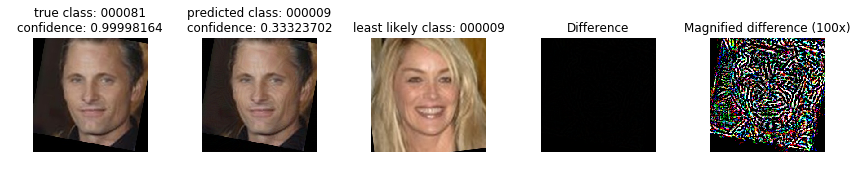

In [71]:
plot_IFGSM_target(vgg, [5])

In [23]:
X_fooling_vgg,_ = batch_IFGSM_target(X_test[:128], vgg, batch=32, max_iter=5, alpha = 0.01)

Fooling batch 0
classified class: [30 34 68  2 34 41 53 43 32 52  2  7 19  3 62 14 56 46 53 44 66 72 72 71
 52 52 57 19 37 67 55 11]
target score(least likely classes): [62 26 66 18  4 66 71 44 63 66 66 54 62 48 66 21 66 35 66 66  6 52 23  8
 66 18 66 62 60 53 11 26]
t: 0
classified class: [16 59 39 28 71 39 28 19 30 52 63 29  7  3 39 67  1 58 21 22 31  8 61 71
 21 62 33 19 16 45 52 52]
target score(least likely classes): [62 26 66 18  4 66 71 44 63 66 66 54 62 48 66 21 66 35 66 66  6 52 23  8
 66 18 66 62 60 53 11 26]
t: 1
classified class: [45 26 70 54  4 61 15 44 41  7  2 54 21  1 67  7 32  1 23 39 35 52 17 46
 14 18 62 58 60 55 59 72]
target score(least likely classes): [62 26 66 18  4 66 71 44 63 66 66 54 62 48 66 21 66 35 66 66  6 52 23  8
 66 18 66 62 60 53 11 26]
t: 2
classified class: [62 26 49 36  4 66 71 44 63 66 36 54 62 48 62 21 13 61 72 45 30 52 23  8
 37 18  7 62 60 28 11 26]
target score(least likely classes): [62 26 66 18  4 66 71 44 63 66 66 54 62 48 66 21 66 35 66 66

In [24]:
X_fooling_resNet,_ = batch_IFGSM_target(X_test[:128], resNet, batch=32, max_iter=5, alpha = 0.01)

Fooling batch 0
classified class: [30  6 40  2 29 29 28 43 30 52  2 38 19  3 62 14 56 46 53 44 66 72 72 71
 52  2  2 19 26 13 55 11]
target score(least likely classes): [11 32 23 46 48 23 27 26 52 56 46 22 11 55 26 47 59 66 59 15  6 62  4 47
 49 72 55  6 11 54 47 16]
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

t: 0
classified class: [34 29 39 53 14  9  2 62 17 62 59 22  8 54 62 14 39 44 63 40  5  8 20 71
  8 51  3 57 29 38 18 54]
target score(least likely classes): [11 32 23 46 48 23 27 26 52 56 46 22 11 55 26 47 59 66 59 15  6 62  4 47
 49 72 55  6 11 54 47 16]
t: 1
classified class: [11  1 30 46 48  6 50 26 52 56 46 22 11  3 26 47 60 66 59 49 54 62  4 47
 49 72 42 67 11 54 47 16]
target score(least likely classes): [11 32 23 46 48 23 27 26 52 56 46 22 11 55 26 47 59 66 59 15  6 62  4 47
 49 72 55  6 11 54 47 16]
t: 2
classified class: [11 

In [24]:
X_fooling_inception,_ = batch_IFGSM_target(X_test[:128], inception, batch=32, max_iter=5, alpha = 0.01)

Fooling batch 0
classified class: [30  1 43  2 60 41 12 43 30 52  2  7 19  3 62 14 56 46 53 44 66 72 72 71
 52 62  2 19 26 58 55 11]
target score(least likely classes): [43 50 13 11 33 50 31 14 53 66 18 15  1 13 66 68 33  9 13 71  3  4 13  9
 69 11 54 35 51 23 47 36]
t: 0
classified class: [28 60 50 53 29 50 42 35 30 52 24 18 55 40 42  7 12 46 43 60 48 54 66 58
 35 11 62 58 36 66 67 35]
target score(least likely classes): [43 50 13 11 33 50 31 14 53 66 18 15  1 13 66 68 33  9 13 71  3  4 13  9
 69 11 54 35 51 23 47 36]
t: 1
classified class: [43  6 68 11  3 50 39 38 30 52 54 36  1 60 55 71 49 10 19  3  3  4 58  4
 38 11 28  7 66  0 38 36]
target score(least likely classes): [43 50 13 11 33 50 31 14 53 66 18 15  1 13 66 68 33  9 13 71  3  4 13  9
 69 11 54 35 51 23 47 36]
t: 2
classified class: [43 50 52 12 33 50 31  3 54 17 44 35 55  3 66 38 33 68 52 28  3  4 13 58
 69 11 54 35 54  4 28 36]
target score(least likely classes): [43 50 13 11 33 50 31 14 53 66 18 15  1 13 66 68 33  9 13 71

In [25]:
X_fooling_cnn,_ = batch_IFGSM_target(X_test[:128], cnn, batch=32, max_iter=5, alpha = 0.01)

Fooling batch 0
classified class: [30  8 47 10 29 68 17  9 38 63  2  7 19 36 62 14 43 46 53 60 66 72 72 71
 21  6  2 19 58 67 55 11]
target score(least likely classes): [35 51 27 37 27 61 40 34 63 37 64 54 44 27 20 56 14 50 61 23 54 40 28 54
 27 48 14 44  2 40 56 65]
t: 0
classified class: [33 21 11  9 44 69 28 47 19 15 52 61  7 60 60 66 40 21 57 56 70 55 18 71
 35  8 60 17 55 66 38 54]
target score(least likely classes): [35 51 27 37 27 61 40 34 63 37 64 54 44 27 20 56 14 50 61 23 54 40 28 54
 27 48 14 44  2 40 56 65]
t: 1
classified class: [60 60 56 33 63  3 51 72 30 56 62 70 17  3 21  4 70 46 42 44 40 61  7 31
 52 36 55 19 61 38  0 54]
target score(least likely classes): [35 51 27 37 27 61 40 34 63 37 64 54 44 27 20 56 14 50 61 23 54 40 28 54
 27 48 14 44  2 40 56 65]
t: 2
classified class: [ 1 60 49  2 72 43 61 58 70 43 39 32 27 41  9 31  2 58 60 63 39 29 29  7
 52 17 60 30 72 26 66 30]
target score(least likely classes): [35 51 27 37 27 61 40 34 63 37 64 54 44 27 20 56 14 50 61 23

### 4.5 Optimization based method

$\text{minimize} ||\frac{1}{2}(tanh(w) + 1) - x||_{2}^{2} + c \cdot f(\frac{1}{2}(tanh(w) + 1)) $

$f(x^{'}) = max(max(\{Z(x^{'})_{i}:i\neq{t})\} - Z(x^{'})_{t}), -\kappa)$

In [29]:
resNet = load_model('weight_new/ResNet_2.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [30]:
def optimization(X, y_target, model, T=10, c=50, eps=0.01):
    y_target = y_target.astype(np.float32)
    X_fooling = X.copy()
    k = tf.Variable(0, dtype=tf.float32)
    label = np.argmax(y_target, axis=1)[0]
    print("target class: " + str(label))

    ### Build Computational Graph
    w = tf.placeholder(tf.float32, shape = X_fooling.shape)
    x = tf.placeholder(tf.float32, shape = X_fooling.shape)
    values = {x:X_fooling, w:X_fooling, k:0}
    
    outputTensor = model(0.5 * (tf.tanh(w) + 1))
    
    # get i != t indices    
    indices_other = np.array([[0, i] for i in range(OUTPUT_SHAPE) if i != label])
    scores_other = tf.gather_nd(outputTensor, indices_other)
    score_target = tf.gather_nd(outputTensor, [[0, label]])
    
    loss1 = tf.norm(0.5 * (tf.tanh(w) + 1) - x)
    loss2 = c * tf.math.maximum(tf.math.reduce_max(scores_other, keepdims=True) - score_target, -k)
    loss = loss1 + loss2
    
    gradients = tf.gradients(loss, w)
    
    for t in range(T):        
        all_classified_scores, dw = sess.run([outputTensor, gradients], feed_dict=values)
        all_classified_scores, dw = all_classified_scores[0], dw[0]
        values[w] -= eps * dw
        classified_score = np.argmax(all_classified_scores)
 
        if t % 100 == 0:
            print("t: " + str(t))
            print("classified class: " + str(classified_score))
            print("target class: " + str(label))
    
        if classified_score == label:
            print("classified class: " + str(classified_score))
            print("target class: " + str(label))
            return values[w]
        
    return values[w]


def optimization_vec(X, y_target, model, T = 30, c=100, eps=0.01):
    """
    This is likely to run out of memory
    """
    y_target = y_target.astype(np.float32)
    X_fooling = X.copy()
    k = tf.placeholder(shape=(X.shape[0], 1), dtype=tf.float32)
    label = np.argmax(y_target, axis=1)

    ### Build Computational Graph
    w = tf.placeholder(tf.float32, shape = X_fooling.shape)
    x = tf.placeholder(tf.float32, shape = X_fooling.shape)
    values = {x:X_fooling, w:X_fooling, k:np.zeros((X_fooling.shape[0], 1))}
    
    outputTensor = model(0.5 * (tf.tanh(w) + 1))
    
    # get i != t indices    
    indices_other = np.array([[[k, i] for i in range(OUTPUT_SHAPE) if i != label[k]] for k in range(X_fooling.shape[0])])
    scores_other = tf.gather_nd(outputTensor, indices_other)
    score_target = tf.gather_nd(outputTensor, [[[k, label[k]]] for k in range(X_fooling.shape[0])])
    
    loss1 = tf.norm(0.5 * (tf.tanh(w) + 1) - x)
    loss2 = c * tf.math.maximum(tf.math.reduce_max(scores_other, axis=1, keepdims=True) - score_target, -k)
    loss = loss1 + loss2
    
    gradients = tf.gradients(loss, w)
    
    for t in range(T):        
        dw = sess.run(gradients, feed_dict=values)
        dw = dw[0]
        values[w] -= eps * dw 
        if t % 100 == 0:
            print(t)
        
    return values[w]


def plot_optimization(model, i, j):
    """
    i : index for the original image
    j : index for the target image
    """
    X = np.expand_dims(X_train[i], axis=0)
    y = np.expand_dims(y_train[i], axis=0)
    y_fooling_target = np.expand_dims(y_train[j], axis=0)

    X_fooling = optimization(X, y_fooling_target, model) 
    
    label = [j] # The label index of least likely class
    
    model = load_model('weight_new/ResNet_2.h5')

    # Get the confidence of X and X_fooling
    outputTensor = model.output
    correct_scores = tf.gather_nd(outputTensor,
                              tf.stack((tf.range(X.shape[0]), np.argmax(y, axis=1)), axis=1))
    X_confidence = sess.run(correct_scores, feed_dict={model.input:X})
    
    correct_scores = tf.gather_nd(outputTensor,
                              tf.stack((tf.range(X_fooling.shape[0]), label), axis=1))  
    X_fooling_confidence = sess.run(correct_scores, feed_dict={model.input:0.5 * (np.tanh(X_fooling) + 1)})
    
    for i in range(len(X_fooling)):
        plt.figure(figsize=(12,7))
        plt.subplot(1, 5, 1)
        plt.imshow(X[i])
        plt.axis('off')
        plt.title("true class: " + label_name_list[np.argmax(y, axis=1)[i]] + \
                  "\n" + "confidence: " + str(X_confidence[i]))
        plt.subplot(1, 5, 2)
        plt.imshow(0.5 * (np.tanh(X_fooling[i]) + 1))
        plt.title("predicted class: " + label_name_list[label[i]] + \
                  "\n" + "confidence: " + str(X_fooling_confidence[i]))
        plt.axis('off')
        plt.subplot(1, 5, 3)
        plt.imshow(X_train[label[i]])
        plt.title("least likely class: " + label_name_list[label[i]])
        plt.axis('off')
        plt.subplot(1, 5, 4)
        plt.title('Difference')
        plt.imshow(X[i]-X_fooling[i])
        plt.axis('off') 
        plt.subplot(1, 5, 5)
        plt.title('Magnified difference (100x)')
        plt.imshow(100 * (X[i]-(0.5 * (np.tanh(X_fooling[i]) + 1))))
        plt.axis('off')
        plt.gcf().tight_layout()
    
def plot_optimization_vec(model, i, j):
    """
    i : index for the original image
    j : index for the target image
    """
    X = np.expand_dims(X_train[i], axis=0)
    y = np.expand_dims(y_train[i], axis=0)
    y_fooling_target = np.expand_dims(y_train[j], axis=0)

    X_fooling = optimization_vec(X, y_fooling_target, model)
        
    label = [j] # The label index of least likely class

    # Get the confidence of X and X_fooling
    outputTensor = model.output
    correct_scores = tf.gather_nd(outputTensor,
                              tf.stack((tf.range(X.shape[0]), np.argmax(y, axis=1)), axis=1))
    X_confidence = sess.run(correct_scores, feed_dict={model.input:X})
    
    correct_scores = tf.gather_nd(outputTensor,
                              tf.stack((tf.range(X_fooling.shape[0]), classified_score), axis=1))  
    X_fooling_confidence = sess.run(correct_scores, feed_dict={model.input:X_fooling})
    
    for i in range(len(X_fooling)):
        plt.figure(figsize=(12,7))
        plt.subplot(1, 5, 1)
        plt.imshow(X[i])
        plt.axis('off')
        plt.title("true class: " + label_name_list[np.argmax(y, axis=1)[i]] + \
                  "\n" + "confidence: " + str(X_confidence[i]))
        plt.subplot(1, 5, 2)
        plt.imshow(X_fooling[i])
        plt.title("predicted class: " + label_name_list[classified_score[i]] + \
                  "\n" + "confidence: " + str(X_fooling_confidence[i]))
        plt.axis('off')
        plt.subplot(1, 5, 3)
        plt.imshow(X_train[label[i]])
        plt.title("least likely class: " + label_name_list[label[i]])
        plt.axis('off')
        plt.subplot(1, 5, 4)
        plt.title('Difference')
        plt.imshow(X[i]-X_fooling[i])
        plt.axis('off') 
        plt.subplot(1, 5, 5)
        plt.title('Magnified difference (100x)')
        plt.imshow(100 * (X[i]-X_fooling[i]))
        plt.axis('off')
        plt.gcf().tight_layout()
    
def batch_Optimization(X_train, y_train, model, batch=64, max_iter=300, c=50, eps=0.01):
    N = X_train.shape[0]
    X_fooling = np.zeros(X_train.shape)
    for i in range(0, N, batch):
        print("Fooling batch " + str(i))
        j = np.minimum(N-1, i + batch)
        X_train_batch, y_train_batch = X_train[i:j], y_train[i:j]
        X_fooling_batch = optimization_vec(X_train_batch, y_train_batch, model, T=max_iter, c=c, eps=eps)
        X_fooling[i:j] = X_fooling_batch

    return X_fooling

In [22]:
X_fooling_vgg = batch_Optimization(X_test[:32], y_test[1:33], vgg, batch=32, max_iter=30, c=100, eps=1)  

Fooling batch 0
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
0


In [23]:
predictions_vgg_optimization = vgg.predict(X_fooling_vgg)
np.mean(np.argmax(predictions_vgg_optimization, axis=1) == np.argmax(y_test[32:64], axis=1))

0.03125

In [46]:
X_fooling_vgg = batch_Optimization(X_test[:128], y_test[128:256], vgg, batch=32, max_iter=300, c=50, eps=0.01)  

Fooling batch 0
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
0
100
200
Fooling batch 32
0
100
200
Fooling batch 64
0
100
200
Fooling batch 96
0
100
200


In [48]:
predictions_vgg_optimization = vgg.predict(X_fooling_vgg)
np.mean(np.argmax(predictions_vgg_optimization, axis=1) == np.argmax(y_test[128:256], axis=1))

0.078125

In [ ]:
X_fooling_inception = batch_Optimization(X_test[:128], y_test[128:256], inception, batch=32, max_iter=300, c=50, eps=0.01)


Fooling batch 0
0
100
200
Fooling batch 32
0
100
200
Fooling batch 64


In [38]:
X_fooling_resNet_optimization = batch_Optimization(X_test[:128], y_test[128:256], resNet, batch=16, max_iter=300, c=50, eps=0.01)


Fooling batch 0
0
100
200
Fooling batch 16
0
100
200
Fooling batch 32
0
100
200
Fooling batch 48
0
100
200
Fooling batch 64
0
100
200
Fooling batch 80
0
100
200
Fooling batch 96
0
100
200
Fooling batch 112
0
100
200


In [39]:
predictions_resNet_optimization = resNet.predict(X_fooling_resNet_optimization)

target class: 63
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
t: 0
classified class: 70
target class: 63
classified class: 63
target class: 63


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


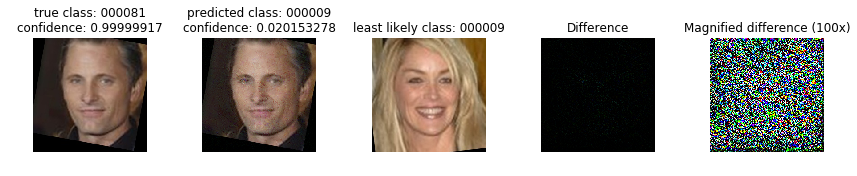

In [22]:
plot_optimization(resNet, i=5, j=6)

target class: 63
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
t: 0
classified class: 70
target class: 63
classified class: 63
target class: 63


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


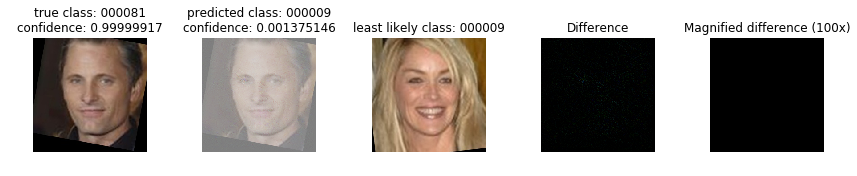

In [31]:
plot_optimization(resNet, i=5, j=6)

target class: 37
t: 0
classified class: 19
target class: 37
t: 100
classified class: 5
target class: 37
t: 200
classified class: 1
target class: 37


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


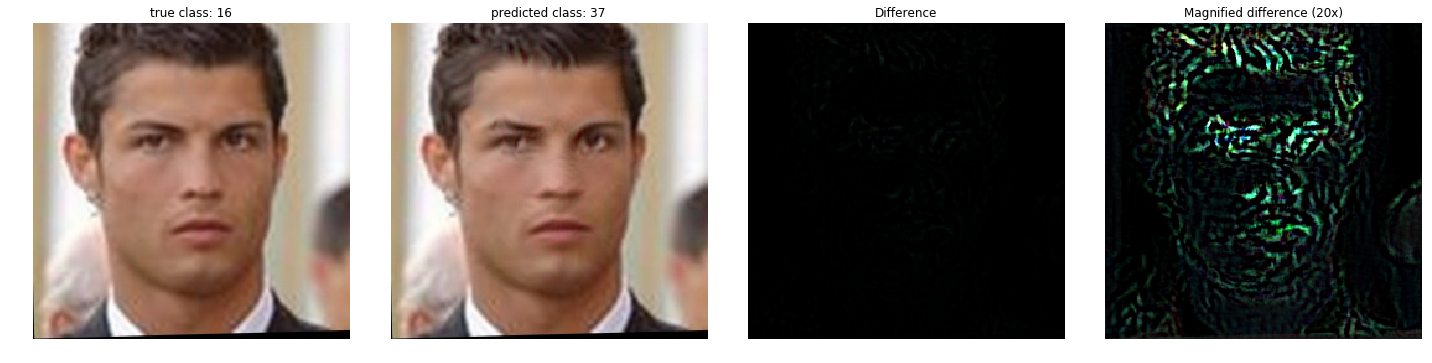

In [351]:
plot_optimization(vgg, i=4, j=3)

### 4.6 LBFGS

$\text{minimize }  c|r| + \text{loss}_{f}(x + r, l) \text{ subject to } x + r \in [0, 1]$

$x_{t+1} = x_{t} + \epsilon \frac{\nabla_{x_{t}}(\text{loss}_{f})}{||\nabla_{x_{t}}(\text{loss}_{f})||_{2}}$

In [73]:
## https://arxiv.org/pdf/1312.6199.pdf
def LBFGS(X, model, max_iter=20, eps=1):
    """
    Fast Gradient Sign Method
    Return the fooling image
    """
    X_fooling = X.copy()
    values = {model.input:X_fooling}
    
    outputTensor = None
    try:
        outputTensor = model.get_layer('output').output
    except:
        outputTensor = model.get_layer('output_layer').output
    
    all_classified_scores = sess.run(outputTensor, feed_dict=values)
    classified_score = np.argmax(all_classified_scores, axis=1)
    print("classified score: " + str(classified_score))

    label = np.argmin(all_classified_scores, axis=1)
    print("target score(least likely classes): " + str(label))
    
    correct_scores = tf.gather_nd(outputTensor,
                              tf.stack((tf.range(X_fooling.shape[0]), label), axis=1))
    gradients = K.gradients(correct_scores, model.input)

    if (classified_score != label).any():
        print("There's invalid example because the model makes a wrong prediction")
    
    for i in range(max_iter):
    #     for t in range(100):

    #     loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels = y,logits = outputTensor)
    #     gradients = K.gradients(loss, model.input)

        dX = sess.run(gradients, feed_dict={model.input:X_fooling})[0]

        norms = np.sqrt(np.sum(np.square(np.linalg.norm(dX,axis = (1,2))),axis = 1))
        X_fooling += eps * dX / norms.reshape(-1,1,1,1)
        values[model.input] = X_fooling

        all_classified_scores = sess.run(model.output, feed_dict=values)
        classified_score = np.argmax(all_classified_scores, axis=1)

    #     print("t: " + str(t))
        print("classified score: " + str(classified_score))
        print("target score(least likely classes): " + str(label))

        if (classified_score == label).all():
            return (X_fooling, classified_score, label)
        
    return (X_fooling, classified_score, label)


def plot_LBFGS(model, index_list, max_iter=20, eps = 1):
    X = X_train[index_list]
    y = y_train[index_list]
    X_fooling, classified_score, label = LBFGS(X, model, max_iter=max_iter, eps=eps)  
               
    # Get the confidence of X and X_fooling
    outputTensor = model.output
    correct_scores = tf.gather_nd(outputTensor,
                              tf.stack((tf.range(X.shape[0]), np.argmax(y, axis=1)), axis=1))
    X_confidence = sess.run(correct_scores, feed_dict={model.input:X})
    
    correct_scores = tf.gather_nd(outputTensor,
                              tf.stack((tf.range(X_fooling.shape[0]), classified_score), axis=1))  
    X_fooling_confidence = sess.run(correct_scores, feed_dict={model.input:X_fooling})
    
    for i in range(len(X_fooling)):
        plt.figure(figsize=(12,7))
        plt.subplot(1, 5, 1)
        plt.imshow(X[i])
        plt.axis('off')
        plt.title("true class: " + label_name_list[np.argmax(y, axis=1)[i]] + \
                  "\n" + "confidence: " + str(X_confidence[i]))
        plt.subplot(1, 5, 2)
        plt.imshow(X_fooling[i])
        plt.title("predicted class: " + label_name_list[classified_score[i]] + \
                  "\n" + "confidence: " + str(X_fooling_confidence[i]))
        plt.axis('off')
        plt.subplot(1, 5, 3)
        plt.imshow(X_train[label[i]])
        plt.title("least likely class: " + label_name_list[label[i]])
        plt.axis('off')
        plt.subplot(1, 5, 4)
        plt.title('Difference')
        plt.imshow(X[i]-X_fooling[i])
        plt.axis('off') 
        plt.subplot(1, 5, 5)
        plt.title('Magnified difference (100x)')
        plt.imshow(100 * (X[i]-X_fooling[i]))
        plt.axis('off')
        plt.gcf().tight_layout()
        
def batch_LBFGS(X_train, model, batch=64, max_iter=20, eps = 0.1):
    N = X_train.shape[0]
    correct_count = 0
    X_fooling = np.zeros(X_train.shape)
    least_likely_classes = np.zeros(X_train.shape[0])
    for i in range(0, N, batch):
        print("Fooling batch " + str(i))
        j = np.minimum(N-1, i + batch)
        X_train_batch = X_train[i:j]
        X_fooling_batch, classified_batch, label = LBFGS(X_train_batch, model, max_iter = max_iter, eps = eps)
        correct_count += np.sum((classified_batch == label).astype(int))
        X_fooling[i:j] = X_fooling_batch
        least_likely_classes[i:j] = label
        
    print("Percentage of successful attacks:")
    print(float(correct_count) / float(N))

    return (X_fooling, least_likely_classes)
        


classified score: [70]
target score(least likely classes): [6]
There's invalid example because the model makes a wrong prediction
classified score: [70]
target score(least likely classes): [6]
classified score: [17]
target score(least likely classes): [6]
classified score: [8]
target score(least likely classes): [6]
classified score: [6]
target score(least likely classes): [6]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


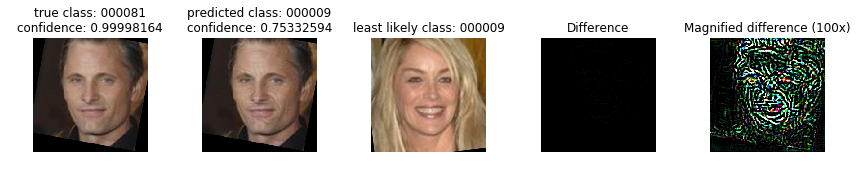

In [74]:
plot_LBFGS(vgg, [5])

In [29]:
X_fooling,_ = batch_LBFGS(X_test[:128], vgg, batch=32, max_iter=5, eps = 1)

Fooling batch 0
classified score: [30 34 68  2 34 41 53 43 32 52  2  7 19  3 62 14 56 46 53 44 66 72 72 71
 52 52 57 19 37 67 55 11]
target score(least likely classes): [62 26 66 18  4 66 71 44 63 66 66 54 62 48 66 21 66 35 66 66  6 52 23  8
 66 18 66 62 60 53 11 26]
There's invalid example because the model makes a wrong prediction
classified score: [30 34  8  2 29 39 53 60 30 52  2  7  7  3 62 14 56 46 63 44 67 72 72 71
 52 52 57 19 16 67 55 11]
target score(least likely classes): [62 26 66 18  4 66 71 44 63 66 66 54 62 48 66 21 66 35 66 66  6 52 23  8
 66 18 66 62 60 53 11 26]
classified score: [58 34  1  2 71 39 53 44 30 52  2 18  7  3 62 14 50 46 53 60 31 72 72 71
 52 21 33 19 16 67 52 52]
target score(least likely classes): [62 26 66 18  4 66 71 44 63 66 66 54 62 48 66 21 66 35 66 66  6 52 23  8
 66 18 66 62 60 53 11 26]
classified score: [58 24 70 28  4 39 53 44 30 52 66 54  7  3 62 14 50 46 66 39 67 52 72 71
 52 18 33 19 60 67 52 52]
target score(least likely classes): [62 26 6

In [30]:
X_fooling,_ = batch_LBFGS(X_test[:128], inception, batch=32, max_iter=5, eps = 1)

Fooling batch 0
classified score: [30  1 43  2 60 41 12 43 30 52  2  7 19  3 62 14 56 46 53 44 66 72 72 71
 52 62  2 19 26 58 55 11]
target score(least likely classes): [43 50 13 11 33 50 31 14 53 66 18 15  1 13 66 68 33  9 13 71  3  4 13  9
 69 11 54 35 51 23 47 36]
There's invalid example because the model makes a wrong prediction
classified score: [63  1 11 35 29 49 28 43 30 52  2  7 55  3 62 14 12 46  9 60 66 72 72 71
 35 44 62 58 26 55 55 35]
target score(least likely classes): [43 50 13 11 33 50 31 14 53 66 18 15  1 13 66 68 33  9 13 71  3  4 13  9
 69 11 54 35 51 23 47 36]
classified score: [43 35 60 11 25 50 31  4 30 52 21 38 21 60 42 14 33 46 63 60  3 26 13 71
 58 11 21 19 51  0 58 36]
target score(least likely classes): [43 50 13 11 33 50 31 14 53 66 18 15  1 13 66 68 33  9 13 71  3  4 13  9
 69 11 54 35 51 23 47 36]
classified score: [43 60 68 11 33 50 31  4 30 52 18 46  8 60 42 14 33 46 13 60  3  4 13 71
 69 59 54 55 51  0 47 36]
target score(least likely classes): [43 50 1

In [31]:
X_fooling,_ = batch_LBFGS(X_test[:128], cnn, batch=32, max_iter=5, eps = 1)

Fooling batch 0
classified score: [30  8 47 10 29 68 17  9 38 63  2  7 19 36 62 14 43 46 53 60 66 72 72 71
 21  6  2 19 58 67 55 11]
target score(least likely classes): [35 51 27 37 27 61 40 34 63 37 64 54 44 27 20 56 14 50 61 23 54 40 28 54
 27 48 14 44  2 40 56 65]
There's invalid example because the model makes a wrong prediction
classified score: [ 1 10 11 30 26  7 40 33 19 55  2 67  7  8  8 17 40 39 60 44 10 72 55 70
 17  8 45 50  8  8 45  1]
target score(least likely classes): [35 51 27 37 27 61 40 34 63 37 64 54 44 27 20 56 14 50 61 23 54 40 28 54
 27 48 14 44  2 40 56 65]
classified score: [35 51 24 34  3  7 40 34 63  8 17 54  7  8  8  8 62  8 35  8 54 61  8  8
  8 50  8  8  8  8  8  8]
target score(least likely classes): [35 51 27 37 27 61 40 34 63 37 64 54 44 27 20 56 14 50 61 23 54 40 28 54
 27 48 14 44  2 40 56 65]
classified score: [35 51 10 60 26 61 40 34 63  8  2 54  7  8  8  8 62  8 61 12 54 52  8  8
  8 30  8  8  8  8  8  8]
target score(least likely classes): [35 51 2

In [26]:
X_fooling,_ = batch_LBFGS(X_test[:128], resNet, batch=32, max_iter=5, eps = 1)

Fooling batch 0
classified score: [30  6 40  2 29 29 28 43 30 52  2 38 19  3 62 14 56 46 53 44 66 72 72 71
 52  2  2 19 26 13 55 11]
target score(least likely classes): [11 32 23 46 48 23 27 26 52 56 46 22 11 55 26 47 59 66 59 15  6 62  4 47
 49 72 55  6 11 54 47 16]
There's invalid example because the model makes a wrong prediction
classified score: [18  1 10  3 29 34 28 43 30 52  2  9 27  3 62 14 56 46 53 63 66 72 72 71
 52  2 42 19 26 38 55 11]
target score(least likely classes): [11 32 23 46 48 23 27 26 52 56 46 22 11 55 26 47 59 66 59 15  6 62  4 47
 49 72 55  6 11 54 47 16]
classified score: [11  1 63 46 48 34 36 26 30 52 25 22 11  3 62 14 56 46 59 63  6 72 20 71
 49 72 55 19 11 26 47 11]
target score(least likely classes): [11 32 23 46 48 23 27 26 52 56 46 22 11 55 26 47 59 66 59 15  6 62  4 47
 49 72 55  6 11 54 47 16]
classified score: [11  1 23 46 48 23 27 26 52 52 46 22 11 55 26 14 59 66 59 15  6 62  4 71
 49 72 55 16 11 54 47 16]
target score(least likely classes): [11 32 2

## 5. Results

### 5.1 Successful Rate

In [3]:
od_nontarget = OrderedDict() 
od_nontarget['VGG'] = [0.6754,0.9771,0.9856]
od_nontarget['ResNet'] = [0.9442,0.9848,0.9961]
od_nontarget['Inception'] = [0.9408,0.9958,0.99609375]
od_nontarget['CNN'] = [0.9146,0.99408,0.9844]
# initialise data of lists. 

# Creates pandas DataFrame. 
df_nontarget = pd.DataFrame(od_nontarget, index =["FGM(eps=1)","FGSM (eps=0.01)","I-FGSM (iter=5, alpha=0.002)"]) 

od_target = OrderedDict() 
od_target['VGG'] = [0.7031,0.9766]
od_target['ResNet'] = [0.9922,0.9922]
od_target['Inception'] = [0.8828,0.6562]
od_target['CNN'] = [0.3359,0.0156]
# initialise data of lists. 

# Creates pandas DataFrame. 
df_target = pd.DataFrame(od_target, index =["L-BFGS (max_iter=5, eps=1)", "IFGSM with target (max_iter=5, alpha=0.01)"])



In [5]:
df_nontarget

,VGG,ResNet,Inception,CNN
FGM(eps=1),0.6754,0.9442,0.940800,0.91460
FGSM (eps=0.01),0.9771,0.9848,0.995800,0.99408
"I-FGSM (iter=5, alpha=0.002)",0.9856,0.9961,0.996094,0.98440


In [6]:
df_target

,VGG,ResNet,Inception,CNN
"L-BFGS (max_iter=5, eps=1)",0.7031,0.9922,0.8828,0.3359
"IFGSM with target (max_iter=5, alpha=0.01)",0.9766,0.9922,0.6562,0.0156


### 5.2 Evaluation of Transferability
#### 5.2.1 Non targeted attack train on one net and transfer to other models

In [25]:
X_fooling_FGSM = batch_FGSM(X_test, y_test, resNet, batch=16, eps=1)

Fooling batch 0
ground truth class: [30  6 43  2 29 69 53 43 30 52  2  7 19  3 62 14]
classified class: [30  6 40  2 29 29 28 43 30 52  2 38 19  3 62 14]
Invalid example exits where the model makes a wrong prediction
Classified: [52 25 25 25 25 25 25 25 25 25 52 25 25 52 52 25]
Ground truth: [30  6 43  2 29 69 53 43 30 52  2  7 19  3 62 14]
Fooling batch 16
ground truth class: [56 46 53 44 66 72 72 71 52  2 57 19 26 67 55 11]
classified class: [56 46 53 44 66 72 72 71 52  2  2 19 26 13 55 11]
Invalid example exits where the model makes a wrong prediction
Classified: [25 25 25 52 25 25 52 52 52 25 25 25 25 25 52 52]
Ground truth: [56 46 53 44 66 72 72 71 52  2 57 19 26 67 55 11]
Fooling batch 32
ground truth class: [15 44 52 36 48 63 39 10  2 65 42  0 43 43  9 56]
classified class: [15 44 52 36 48 63 72 36  2 65 40  0 43 43 57  2]
Invalid example exits where the model makes a wrong prediction
Classified: [25 25 52 52 25 25 25 25 25 25 25 25 25 52 25 25]
Ground truth: [15 44 52 36 48 63 

Classified: [25 25 25 25 25 52 25 25 25 25 25 25 25 25 25 25]
Ground truth: [47 49 67 50  6 26 47 64 60 46 36 30 45 55 55 55]
Fooling batch 400
ground truth class: [28 20  8 27 49 49 43 30 38 55 48  7 71 71 36 17]
classified class: [28 20  8 27 49 49 43 30 38 55 48 18 71 71 36 70]
Invalid example exits where the model makes a wrong prediction
Classified: [25 52 25 52 52 52 52 25 25 25 52 25 52 25 52 25]
Ground truth: [28 20  8 27 49 49 43 30 38 55 48  7 71 71 36 17]
Fooling batch 416
ground truth class: [18 71 62 72 33 35 48 27 59 35 20 26 57 67 52 27]
classified class: [18 71 62 72 33 20 48 27 59 20 20 26 57 67 52 27]
Invalid example exits where the model makes a wrong prediction
Classified: [25 25 25 52 52 25 52 25 25 52 25 25 52 52 25 25]
Ground truth: [18 71 62 72 33 35 48 27 59 35 20 26 57 67 52 27]
Fooling batch 432
ground truth class: [ 4 13 60 53 12 25  1  2  3 48 52 27 51 42 37 15]
classified class: [ 4 38 60 53 12 24  1  2  3 48 52 27 51 42 37 15]
Invalid example exits where 

Classified: [25 25 52 52 25 25 25 25 25 25 25 52 25 25 52 52]
Ground truth: [23 26 55 14 14 71 28 53 14 57 47 62  0 27  5 25]
Fooling batch 784
ground truth class: [16 62 56 65 60 60 11  8 19 18 22 29 24 13 54 34]
classified class: [16 62 56 65 60 60 59  8 16 18 44 29 24 67 54 24]
Invalid example exits where the model makes a wrong prediction
Classified: [25 25 52 25 25 25 25 25 25 25 25 25 25 25 25 18]
Ground truth: [16 62 56 65 60 60 11  8 19 18 22 29 24 13 54 34]
Fooling batch 800
ground truth class: [41 39 47  4 69 43 60 11 39 47 20 33 23 27 24 57]
classified class: [ 8 42 47  4 69 43 60 11 39 47 20 33 23 27 24 57]
Invalid example exits where the model makes a wrong prediction
Classified: [52 52 25 52 25 25 52 25 25 52 25 25 25 25 52 52]
Ground truth: [41 39 47  4 69 43 60 11 39 47 20 33 23 27 24 57]
Fooling batch 816
ground truth class: [16 60  6 59 37 39 56 26  9 62 71 14 42 47 64 62]
classified class: [16  3  6 59 37 39 56 26 52 62 16 14 42 47 64 24]
Invalid example exits where 

Classified: [52 25 25 25 52 25 25 52 52 25 52 25 25 52 52 25]
Ground truth: [40 68  4 69 21 20 72 24 55 23 14 72 11  4 36 29]
Fooling batch 1168
ground truth class: [26 69 17 44 19 25  0 43 44 18 72 24 46  3]
classified class: [26 69 17 44 19 25  0 43 44 18 72 24 46  3]
Classified: [52 25 25 25 52 25 52 52 25 52 25 25 25 25]
Ground truth: [26 69 17 44 19 25  0 43 44 18 72 24 46  3]
Percentage of successful attacks:
0.9847844463229078


In [ ]:
# np.save("X_fooling_resNet_FGM", X_fooling_FGM)

In [29]:
def transfer_rate(X_fooling, y, models):
    for model_name, model in models.items():
        predictions = model.predict(X_fooling, batch_size=32)
        rate = np.mean(np.argmax(predictions, axis=1) != np.argmax(y, axis=1))
        print(model_name + ":" + str(rate))

In [27]:
# models={"vgg":vgg, "resNet":resNet, "inception":inception, "cnn":cnn})

In [28]:
transfer_rate(X_fooling_FGSM, y_test, models={"vgg":vgg, "inception":inception, "cnn":cnn, "resNet":resNet})

vgg:0.9881656804733728
inception:0.9881656804733728
cnn:0.9847844463229078
resNet:0.9856297548605241


In [43]:
od_FGM = OrderedDict() 
od_FGM['VGG'] = [0.6754, 0.1640, 0.1538, 0.1538]
od_FGM['ResNet'] = [0.3051, 0.9442, 0.2046, 0.1868]
od_FGM['Inception'] = [0.3727, 0.2806, 0.9408, 0.2122]
od_FGM['CNN'] = [0.4649, 0.4573, 0.4590, 0.9146]
# initialise data of lists. 

# Creates pandas DataFrame. 
df_FGM = pd.DataFrame(od_FGM, index =['VGG', 'ResNet', 'Inception', 'CNN']) 

od_FGSM = OrderedDict() 
od_FGSM['VGG'] = [0.9771,0.9882,0.9890,0.9839]
od_FGSM['ResNet'] = [0.9755, 0.9848, 0.9873, 0.9873]
od_FGSM['Inception'] = [0.9865, 0.9881, 0.9958, 0.9873]
od_FGSM['CNN'] = [0.9831, 0.9856, 0.9806, 0.99408]
# initialise data of lists. 

# Creates pandas DataFrame. 
df_FGSM = pd.DataFrame(od_FGSM, index =['VGG', 'ResNet', 'Inception', 'CNN'])

In [31]:
df_FGSM

,VGG,ResNet,Inception,CNN
VGG,0.9771,0.9755,0.9865,0.98310
ResNet,0.9882,0.9848,0.9881,0.98560
Inception,0.9890,0.9873,0.9958,0.98060
CNN,0.9839,0.9873,0.9873,0.99408


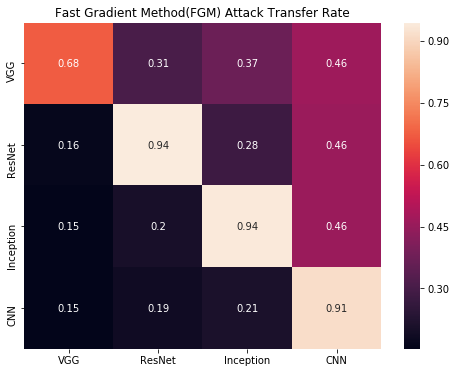

In [66]:
plt.figure(figsize=(8,6))
sns.heatmap(df_FGM, cbar=True, annot=True)
plt.title("Fast Gradient Method(FGM) Attack Transfer Rate")
plt.show()

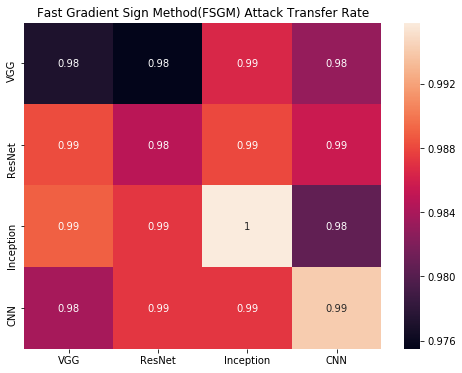

In [44]:
plt.figure(figsize=(8,6))
sns.heatmap(df_FGSM, cbar=True, annot=True)
plt.title("Fast Gradient Sign Method(FSGM) Attack Transfer Rate")
plt.show()

#### 5.2.2 Targeted Attack Transfer to Other

In [23]:
def transfer_rate_target(X_fooling, y, models):
    for model_name, model in models.items():
        predictions = model.predict(X_fooling, batch_size=32)
        rate = np.mean(np.argmax(predictions, axis=1) == y)
        print(model_name + ":" + str(rate))

In [54]:
X_fooling_vgg, least_likely_classes = batch_LBFGS(X_test[:128], vgg, batch=16, max_iter=5, eps = 1)

Fooling batch 0
classified score: [30 34 68  2 34 41 53 43 32 52  2  7 19  3 62 14]
target score(least likely classes): [62 26 66 18  4 66 71 44 63 66 66 54 62 48 66 21]
There's invalid example because the model makes a wrong prediction
classified score: [30 34  8  2 29 39 53 60 30 52  2  7  7  3 62 14]
target score(least likely classes): [62 26 66 18  4 66 71 44 63 66 66 54 62 48 66 21]
classified score: [58 34  1  2 71 39 53 44 30 52  2 18  7  3 62 14]
target score(least likely classes): [62 26 66 18  4 66 71 44 63 66 66 54 62 48 66 21]
classified score: [58 24 70 28  4 39 53 44 30 52 66 54  7  3 62 14]
target score(least likely classes): [62 26 66 18  4 66 71 44 63 66 66 54 62 48 66 21]
classified score: [58  3 66 21  4 39 53 44 63 52 66 54  7  3 62 14]
target score(least likely classes): [62 26 66 18  4 66 71 44 63 66 66 54 62 48 66 21]
classified score: [58 26 66 18  4 66 15 44 63 52 66 54  7  3 62 21]
target score(least likely classes): [62 26 66 18  4 66 71 44 63 66 66 54 62 48 

classified score: [36 42  3 54 63 39 64  7  8 63 39  8 42 66 10 39]
target score(least likely classes): [18 42 54 54 63 66 64  3 63 63 51 23 42 66 10 66]
classified score: [36 42  3 54 63 39 64  7 63 63 39  8 42 66 10 66]
target score(least likely classes): [18 42 54 54 63 66 64  3 63 63 51 23 42 66 10 66]
classified score: [18 42 54 54 63 66 64  7 63 63 39  8 42 66 10 66]
target score(least likely classes): [18 42 54 54 63 66 64  3 63 63 51 23 42 66 10 66]
classified score: [18 42 54 54 63 66 64  7 63 63 51 23 42 66 10 66]
target score(least likely classes): [18 42 54 54 63 66 64  3 63 63 51 23 42 66 10 66]
classified score: [18 42 54 54 63 66 64  7 63 63 51 23 42 66 10 66]
target score(least likely classes): [18 42 54 54 63 66 64  3 63 63 51 23 42 66 10 66]
classified score: [18 42 54 54 63 66 64  7 63 63 51 23 42 66 10 66]
target score(least likely classes): [18 42 54 54 63 66 64  3 63 63 51 23 42 66 10 66]
classified score: [18 42 54 54 63 66 64  3 63 63 51 23 42 66 10 66]
target s

classified score: [63 23 10 14 44 26 18 44 44 27 35 66 66 57  2 67]
target score(least likely classes): [63 23 10 14 44 26 18 14 44 27 35 66 66 57  2 67]
classified score: [63 23 10 14 44 26 18 44 44 27 35 66 66 57  2 67]
target score(least likely classes): [63 23 10 14 44 26 18 14 44 27 35 66 66 57  2 67]
classified score: [63 23 10 14 44 26 18 14 44 27 35 66 66 57  2 67]
target score(least likely classes): [63 23 10 14 44 26 18 14 44 27 35 66 66 57  2 67]
classified score: [63 23 10 14 44 26 18 14 44 27 35 66 66 57  2 67]
target score(least likely classes): [63 23 10 14 44 26 18 14 44 27 35 66 66 57  2 67]
classified score: [63 23 10 14 44 26 18 14 44 27 35 66 66 57  2 67]
target score(least likely classes): [63 23 10 14 44 26 18 14 44 27 35 66 66 57  2 67]
classified score: [63 23 10 14 44 26 18 14 44 27 35 66 66 57  2 67]
target score(least likely classes): [63 23 10 14 44 26 18 14 44 27 35 66 66 57  2 67]
classified score: [63 23 10 14 44 26 18 14 44 27 35 66 66 57  2 67]
target s

In [55]:
transfer_rate_target(X_fooling_vgg, least_likely_classes, models={"vgg":vgg, "inception":inception, "cnn":cnn, "resNet":resNet})


vgg:0.9921875
inception:0.0546875
cnn:0.0
resNet:0.109375


In [57]:
od_IFGSM_target = OrderedDict() 
od_IFGSM_target['VGG'] = [0.9766,0.0,0.0,0.0]
od_IFGSM_target['ResNet'] = [0.0,0.9922,0.0,0.0]
od_IFGSM_target['Inception'] = [0.0,0.0,0.7187,0.0]
od_IFGSM_target['CNN'] = [0.0,0.0,0.0,0.0156]
# initialise data of lists. 

# Creates pandas DataFrame. 
df_IFGSM_target = pd.DataFrame(od_IFGSM_target, index =['VGG', 'ResNet', 'Inception', 'CNN']) 

od_LBFGS_target = OrderedDict() 
od_LBFGS_target['VGG'] = [0.7031,0.0,0.015625,0.0]
od_LBFGS_target['ResNet'] = [0.0,0.9922,0.0,0.0]
od_LBFGS_target['Inception'] = [0.0,0.0,0.8671,0.0]
od_LBFGS_target['CNN'] = [0.0,0.0,0.0,0.3359]
# initialise data of lists. 

# Creates pandas DataFrame. 
df_LBFGS_target = pd.DataFrame(od_LBFGS_target, index =['VGG', 'ResNet', 'Inception', 'CNN']) 



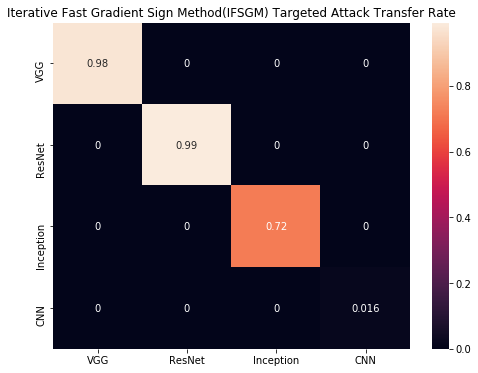

In [33]:
plt.figure(figsize=(8,6))
sns.heatmap(df_IFGSM_target, cbar=True, annot=True)
plt.title("Iterative Fast Gradient Sign Method(IFSGM) Targeted Attack Transfer Rate")
plt.show()

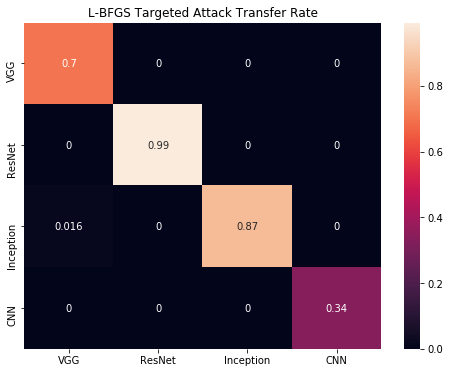

In [59]:
plt.figure(figsize=(8,6))
sns.heatmap(df_LBFGS_target, cbar=True, annot=True)
plt.title("L-BFGS Targeted Attack Transfer Rate")
plt.show()